<a href="https://colab.research.google.com/github/nghiemminh/retail-analysis/blob/main/Retail_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project Overview**
This project analyzes a retail data (Kaggle) thoroughly on many aspects such as Revenue, Orders, Products, Customers with the goal of deriving actionable insights to improve business performance. The project also includes KMean clustering for customer segmentation, time-series forecasting for sale prediction.
## **Key Insight**
###**2.1. Revenue Overview**
- Sales growth decrease in 2014 but is still good in comparison with industry average
- Sales has yearly seasonal pattern

###**2.2 Order Analysis**
####**2.2.1. Overview of Orders**
- While order quantity grows over time, AOV shows a downward trend
- Some orders are sold at loss

####**2.2.2. Time of Order**
- Order Quantity for each year shows an exact seasonal pattern (increase/decrease at the same time)
- Order Quantity are similar for each weekday, but drop significantly at weekend
- Reorder tends to happen soon after purchase

####**2.2.3. Shipment**
- Premium Ship Mode tend to go hand in hand with premium Order Priority, and vice versa
- Same Day ship mode 's on-time delivery percentage (95.8%) is nearly equal [UPS on-time delivery rate (96.5%)](https://colab.research.google.com/drive/1eldpg4Nmm5KrmNGxz1dsg-Ph9z1GeUvK#scrollTo=R6MLfaxPAfI8&line=22&uniqifier=1) (largest logistic company).
- Average days of shipment is stable while order quantity increase 6 times larger
- Delivery service is consistent regardless of when customers order
--> Delivery service is very good

###**2.3. Product Analysis**
####**2.3.1. Important Product**
- Phones is current Source of Revenue due to largest sales but will soon step into saturation stage (low margin, lowest growth)  
- Copiers is most important subcategory due to good current performance and highest future potential. It is future Source of Growth due to highest growth, third largest sale, and large margin
- Accessories is also a core subcategory in the future after Copiers due to large margin and growth
- Paper with its highest margin can bring profit if is leveraged properly
- Tables, while genrateing good revenue, is in decline stage, and bring loss to company

####**2.3.2. Product Sale at Loss**
- 24% products are sale at loss which is very large
- Loss is mainly due to high Discount. Company gives high discount because they want to get rid of products/subcategories ASAP (in case of Tables), or price competition (in case of Phones)

###**2.4. Customer Analysis**
####**2.4.1. Overview of Customer**
- New customer decrease significantly overtime
- Despite of decrease in new customer, sale and order quantity grow annually due to: (1) nearly 100% customers are repeat customer, (2) each customer order many times, (3) average order per customer increase annually
--> Successfully establish a Loyal customer base, but relies on them heavily

####**2.4.2. Customer Segmentation with KMeans**
- High value: mainly care about intrinsic value of products and willing to pay large amount of money. This segment brings most revenue and profit
- High Margin: shows outstanding profit margin, could help increase margin for company
- Low Value: price is this segment's main concern. They typically buy products with ~50% discount. This segment could help company liquidate products that will be out of date soon.
- High Value buys more Paper and Chair than. Low Value and High Margin share a similar preference across products, and buy much more Art, Binder, and Storage.
- The number of new customers of 3 segments decline. However, new customers in High Value declined sharply. After Q3/2012, there is no more new customers in this segment --> serious problem.

###**3. Sale Prediction with XGBoost, LSTM and Prophet**
- XGBoost: Its predictions are closed to actual values. It achieves **1.5% MAPE on Test set** which is excellent.
- LSTM and Prophet: performance on test set is similar, however, Prophet shows overfitting.

##**Recommendation**
###**1. Product Strategy**
- Allocate more marketing and product development resources to key growth drivers (Copiers and Accessories)
- Reduce cost, and maintain market share for Phones which is at Saturation stage but can not be phases out yet due to current largest revenue
- Phase out Tables

###**2. Order Management**
- As AOV is on a downward trend, consider bundling complementary products, offering free shipping thresholds, or cross-selling/up-selling.
- The 24% sale at loss indicates that the company should review pricing strategies and optimize inventory management, particularly for Tables and Phones to avoid deep discounting.

###**3. Customer Strategy**
- The decline in new customers, especially within the High Value segment, suggests the need for stronger customer acquisition strategies.
- Offer exclusive deals to High Margin to further capitalize the outstanding profitability
- The Low Value segment can be used to clear inventory, particularly products that are nearing the end of their life cycle.
- Boost customer acquisition to diversify revenue source (rather than relying solely on loyal customer)

###**4. Inventory Management and Delivery**
- Promote "Same-Day Delivery Guarantee" as a USP for High-Value customers.
- Based on the discovery of strong seasonality and the result machine learning model to prepare for the future demand.







In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import tensorflow as tf
import keras as kr
import warnings
color = sns.color_palette()

warnings.filterwarnings('ignore')


In [ ]:
# Connet Colab with Google Drive to import dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Portfolio/EDA_KMneans_LSTM_sale/superstore_dataset2011-2015.csv',
                 encoding='utf-8', encoding_errors='ignore')

In [ ]:
# Take a look at the dataset
pd.options.display.max_columns = None
df.head()

Row ID         Order ID Order Date Ship Date       Ship Mode Customer ID  \
0   42433     AG-2011-2040   1/1/2011  6/1/2011  Standard Class    TB-11280   
1   22253    IN-2011-47883   1/1/2011  8/1/2011  Standard Class    JH-15985   
2   48883     HU-2011-1220   1/1/2011  5/1/2011    Second Class      AT-735   
3   11731  IT-2011-3647632   1/1/2011  5/1/2011    Second Class    EM-14140   
4   22255    IN-2011-47883   1/1/2011  8/1/2011  Standard Class    JH-15985   

     Customer Name      Segment         City            State    Country  \
0  Toby Braunhardt     Consumer  Constantine      Constantine    Algeria   
1      Joseph Holt     Consumer  Wagga Wagga  New South Wales  Australia   
2    Annie Thurman     Consumer     Budapest         Budapest    Hungary   
3     Eugene Moren  Home Office    Stockholm        Stockholm     Sweden   
4      Joseph Holt     Consumer  Wagga Wagga  New South Wales  Australia   

   Postal Code  Market   Region        Product ID         Category  \
0          NaN  Africa   Africa  OFF-TEN-10000025  Office Supplies   
1          NaN    APAC  Oceania   OFF-SU-10000618  Office Supplies   
2          NaN    EMEA     EMEA  OFF-TEN-10001585  Office Supplies   
3          NaN      EU    North   OFF-PA-10001492  Office Supplies   
4          NaN    APAC  Oceania   FUR-FU-10003447        Furniture   

  Sub-Category                 Product Name    Sales  Quantity  Discount  \
0      Storage          Tenex Lockers, Blue  408.300         2       0.0   
1     Supplies     Acme Trimmer, High Speed  120.366         3       0.1   
2      Storage      Tenex Box, Single Width   66.120         4       0.0   
3        Paper  Enermax Note Cards, Premium   44.865         3       0.5   
4  Furnishings   Eldon Light Bulb, Duo Pack  113.670         5       0.1   

    Profit  Shipping Cost Order Priority  
0  106.140          35.46         Medium  
1   36.036           9.72         Medium  
2   29.640           8.17           High  
3  -26.055           4.82           High  
4   37.770           4.70         Medium

# 1. Data cleaning

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          51290 non-null  int64  
 1   Order ID        51290 non-null  object 
 2   Order Date      51290 non-null  object 
 3   Ship Date       51290 non-null  object 
 4   Ship Mode       51290 non-null  object 
 5   Customer ID     51290 non-null  object 
 6   Customer Name   51290 non-null  object 
 7   Segment         51290 non-null  object 
 8   City            51290 non-null  object 
 9   State           51290 non-null  object 
 10  Country         51290 non-null  object 
 11  Postal Code     9994 non-null   float64
 12  Market          51290 non-null  object 
 13  Region          51290 non-null  object 
 14  Product ID      51290 non-null  object 
 15  Category        51290 non-null  object 
 16  Sub-Category    51290 non-null  object 
 17  Product Name    51290 non-null 

*   Post code column lacks 80% values. We do not need Customer Name, so I will drop those two columns
*   OrderDate and ShipDate are in wrong data type


In [ ]:
# Transform two date columns into datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True, format='mixed')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], dayfirst=True, format='mixed')

In [ ]:
# Check for duplicates
number_of_duplicated_row = df.duplicated().sum()
print(f'There are {number_of_duplicated_row} duplicated rows')

There are 0 duplicated rows


In [ ]:
# Delete unnecessary rows
# Row ID, Customer Name, Postal Code are unnecessary
df = df.drop(columns=['Row ID', 'Customer Name', 'Postal Code'])

In [ ]:
# Create some date-related columns for later time-intelligence analysis
df['year'] = df['Order Date'].dt.year.astype(str)
df['month_name'] = df['Order Date'].dt.month_name()
df['week_number'] = df['Order Date'].dt.isocalendar().week.astype(str)
df['day_of_week'] = df['Order Date'].dt.day_name()
df['quarter'] = df['Order Date'].dt.quarter.astype(str)
df['quarter_year'] = df['Order Date'].dt.year.astype(str) + '-Q' + df['Order Date'].dt.quarter.astype(str)
df['month_year'] = df['Order Date'].dt.year.astype(str) + '-' + df['Order Date'].dt.month.astype(str).str.zfill(2)
df['week_year'] = df['Order Date'].dt.year.astype(str) + '-W' + df['Order Date'].dt.isocalendar().week.astype(str).str.zfill(2)
df.head()

Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0     AG-2011-2040 2011-01-01 2011-01-06  Standard Class    TB-11280   
1    IN-2011-47883 2011-01-01 2011-01-08  Standard Class    JH-15985   
2     HU-2011-1220 2011-01-01 2011-01-05    Second Class      AT-735   
3  IT-2011-3647632 2011-01-01 2011-01-05    Second Class    EM-14140   
4    IN-2011-47883 2011-01-01 2011-01-08  Standard Class    JH-15985   

       Segment         City            State    Country  Market   Region  \
0     Consumer  Constantine      Constantine    Algeria  Africa   Africa   
1     Consumer  Wagga Wagga  New South Wales  Australia    APAC  Oceania   
2     Consumer     Budapest         Budapest    Hungary    EMEA     EMEA   
3  Home Office    Stockholm        Stockholm     Sweden      EU    North   
4     Consumer  Wagga Wagga  New South Wales  Australia    APAC  Oceania   

         Product ID         Category Sub-Category  \
0  OFF-TEN-10000025  Office Supplies      Storage   
1   OFF-SU-10000618  Office Supplies     Supplies   
2  OFF-TEN-10001585  Office Supplies      Storage   
3   OFF-PA-10001492  Office Supplies        Paper   
4   FUR-FU-10003447        Furniture  Furnishings   

                  Product Name    Sales  Quantity  Discount   Profit  \
0          Tenex Lockers, Blue  408.300         2       0.0  106.140   
1     Acme Trimmer, High Speed  120.366         3       0.1   36.036   
2      Tenex Box, Single Width   66.120         4       0.0   29.640   
3  Enermax Note Cards, Premium   44.865         3       0.5  -26.055   
4   Eldon Light Bulb, Duo Pack  113.670         5       0.1   37.770   

   Shipping Cost Order Priority  year month_name week_number day_of_week  \
0          35.46         Medium  2011    January          52    Saturday   
1           9.72         Medium  2011    January          52    Saturday   
2           8.17           High  2011    January          52    Saturday   
3           4.82           High  2011    January          52    Saturday   
4           4.70         Medium  2011    January          52    Saturday   

  quarter quarter_year month_year week_year  
0       1      2011-Q1    2011-01  2011-W52  
1       1      2011-Q1    2011-01  2011-W52  
2       1      2011-Q1    2011-01  2011-W52  
3       1      2011-Q1    2011-01  2011-W52  
4       1      2011-Q1    2011-01  2011-W52

In [ ]:
# Create Profit Margin column for future analysis
df['profit_margin'] = df['Profit'] / df['Sales']

The dataset has column for location (City, State, Region, Market) but we do not know whether this is buyer or seller location. Let 's explore

In [ ]:
# I will use groupby with COUNT so that you can see each customer and their location
df.groupby(['Customer ID', 'Country', 'Region', 'Market'])['Order ID'].count().head(15)

Customer ID  Country         Region          Market
AA-10315     Australia       Oceania         APAC       2
             France          Central         EU         1
             Germany         Central         EU         1
             India           Central Asia    APAC       2
             Mexico          North           LATAM      5
             Philippines     Southeast Asia  APAC       6
             Spain           South           EU         1
             United Kingdom  North           EU        13
             United States   Central         US         6
                             East            US         2
                             West            US         3
AA-10375     Afghanistan     Central Asia    APAC       5
             Argentina       South           LATAM      1
             Australia       Oceania         APAC       1
             France          Central         EU         1
Name: Order ID, dtype: int64

You see that the location information of an Customer ID change with each Order. A customer, for example (AA-10315) can not change there location from EU, to APAC, to LATAM. This not only happens for AA-10315, but for all other customer. This makes no sense.

--> So this must be Seller Location.

In [ ]:
# Let 's look at the information about each customer and their order in detail
df[['Customer ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode', 'Order Priority',
   'State', 'Country', 'Region', 'Market', 'Product ID', 'Sales']].sort_values(by=['Customer ID', 'Order ID']).tail(10)

Customer ID         Order ID Order Date  Ship Date       Ship Mode  \
50960    ZD-21925    IN-2012-64081 2012-10-31 2012-11-05  Standard Class   
21810    ZD-21925    IN-2014-63591 2014-12-13 2014-12-18  Standard Class   
20785    ZD-21925  IT-2012-2197138 2012-07-13 2012-07-17  Standard Class   
7773     ZD-21925  IT-2012-3146139 2012-12-12 2012-12-16  Standard Class   
7778     ZD-21925  IT-2012-3146139 2012-12-12 2012-12-16  Standard Class   
27561    ZD-21925  IT-2012-4926272 2012-08-17 2012-08-22  Standard Class   
43428    ZD-21925   MX-2012-105662 2012-11-26 2012-12-03  Standard Class   
38901    ZD-21925   MX-2013-141698 2013-04-24 2013-04-29    Second Class   
29097    ZD-21925   MX-2014-168550 2014-06-18 2014-06-21    Second Class   
10061    ZD-21925   US-2013-147991 2013-05-06 2013-05-10  Standard Class   

      Order Priority                      State        Country  \
50960         Medium           National Capital    Philippines   
21810           High                      Hebei          China   
20785           High  Provence-Alpes-Cte d'Azur         France   
7773          Medium                    Hedmark         Norway   
7778          Medium                    Hedmark         Norway   
27561         Medium                     Berlin        Germany   
43428            Low                      Mxico         Mexico   
38901           High                Mato Grosso         Brazil   
29097       Critical                 Tamaulipas         Mexico   
10061           High                  Tennessee  United States   

               Region Market       Product ID      Sales  
50960  Southeast Asia   APAC  OFF-PA-10002974    46.8765  
21810      North Asia   APAC  FUR-TA-10003576   445.3260  
20785         Central     EU  TEC-CO-10002686   815.7960  
7773            North     EU  TEC-AC-10003172   135.6300  
7778            North     EU  OFF-PA-10003105   133.6800  
27561         Central     EU  FUR-CH-10002782  1127.8080  
43428           North  LATAM  FUR-FU-10001410    87.9840  
38901           South  LATAM  TEC-PH-10002867   872.3200  
29097           North  LATAM  TEC-CO-10002271   590.1174  
10061           South     US  FUR-FU-10004270    16.7200

Customers can order many products for one order. The Order ID column is not unique, the Order ID will be duplicated for each product that customer buys from the same order. This is not a problem, it is just how the data is and it is totally make sense.

Next, I will find whether there are orders that have inconsistent information (same Order ID but different Order Date, Ship Date, Customer ID, Segment, Location). A valid Order ID should has the consistent information, those with inconsistent information should be deleted

In [ ]:
# Aggegrate the dataframe by Order ID for further calculations
order = df.drop(['Product ID', 'Category', 'Sub-Category', 'Product Name', 'Discount', 'profit_margin'], axis=1).groupby([
    'Order ID', 'Order Date', 'Ship Date', 'Customer ID', 'Segment', 'Country', 'Market', 'Region', 'Ship Mode', 'Order Priority']).sum(['Sales', 'Quantity', 'Profit', 'Shipping Cost']).sort_values(by='Order ID').reset_index()

# The number of unique Order ID in original dataframe
unique_order_original = len(set(df['Order ID']))
print(f'The nummber of unique Order ID in original dataframe : {unique_order_original}')

# The number of Order ID after aggregate by Order ID and order information
print(f'The number of Order ID after aggregate : {order.shape[0]}')
print(f'The different between unique Order ID in the orignial dataframe and the row of aggregate data : {order.shape[0]-unique_order_original}')

The nummber of unique Order ID in original dataframe : 25035
The number of Order ID after aggregate : 25754
The different between unique Order ID in the orignial dataframe and the row of aggregate data : 719


From this difference, I assum that we still have duplicated Order ID after aggregate data by Order ID and order information

In [ ]:
dup_order_id = order['Order ID'].duplicated().sum()
print(f'The number of duplicated Order ID in Order dataframe : {dup_order_id}')

The number of duplicated Order ID in Order dataframe : 719


This confirm my assumption. The number of duplicated Order ID are exactly the same with the difference. This indicate that we have orders that have inconsistent order information. Let 's give a look at those orders

In [ ]:
# Create a dataframe of order with the same Order ID but different in other information
duplicated = order[order['Order ID'].duplicated(keep = False) == True].sort_values(by='Order ID')
duplicated.head()

Order ID Order Date  Ship Date Customer ID    Segment  Country  \
31    AG-2012-2220 2012-11-09 2012-11-13     MV-8190   Consumer  Algeria   
32    AG-2012-2220 2012-12-26 2012-12-30     PO-8865   Consumer  Algeria   
2124  CA-2012-9840 2012-06-25 2012-06-29     LB-6735   Consumer   Canada   
2125  CA-2012-9840 2012-11-01 2012-11-05     RR-9525  Corporate   Canada   
3236  CA-2013-3830 2013-03-30 2013-03-30    SC-10770  Corporate   Canada   

      Market  Region       Ship Mode Order Priority    Sales  Quantity  \
31    Africa  Africa  Standard Class         Medium    63.87         1   
32    Africa  Africa  Standard Class           High  1932.24         7   
2124  Canada  Canada  Standard Class         Medium   113.76         2   
2125  Canada  Canada  Standard Class           High   108.66         1   
3236  Canada  Canada        Same Day       Critical    54.66         1   

      Profit  Shipping Cost  
31     20.43           4.60  
32    191.25         172.39  
2124    1.08           9.13  
2125    2.16          10.17  
3236    2.73          15.98

Let 's look at percentage of invalid Order ID account for in the original dataframe rows and total distinct Order ID

In [ ]:
per_row = round(df[df['Order ID'].isin(duplicated['Order ID'])].shape[0] / df.shape[0] * 100, 2)
print(f'The duplicated Order ID account for {per_row}% of the rows in original dataframe')
per_order = round(duplicated.shape[0] / unique_order_original * 100, 2)
print(f'The duplicated Order ID account for {per_order}% of the Order ID')

The duplicated Order ID account for 5.27% of the rows in original dataframe
The duplicated Order ID account for 5.51% of the Order ID


This percentage is small so I will delete those Order ID from both original table and order table

In [ ]:
# Get the duplicated rows from the 'Order ID' column in df
invalid_order_ids = duplicated['Order ID'].unique()

# Remove the rows with invalie 'Order ID' from the original df
df = df[~df['Order ID'].isin(invalid_order_ids)]

# Remove the rows with invalid 'Order ID' from the order table
order = order[~order['Order ID'].isin(invalid_order_ids)]

Now we have already understand columns and clean the data. Let 's explore this dataset in detail

# 2. EDA

## 2.0 Overview of data

In [ ]:
df.describe()

Order Date                      Ship Date  \
count                          48587                          48587   
mean   2013-05-06 06:30:40.936876032  2013-05-10 05:44:01.965957888   
min              2011-01-01 00:00:00            2011-01-03 00:00:00   
25%              2012-06-13 00:00:00            2012-06-17 00:00:00   
50%              2013-06-28 00:00:00            2013-07-02 00:00:00   
75%              2014-05-16 00:00:00            2014-05-20 00:00:00   
max              2014-12-31 00:00:00            2015-01-07 00:00:00   
std                              NaN                            NaN   

              Sales      Quantity      Discount        Profit  Shipping Cost  \
count  48587.000000  48587.000000  48587.000000  48587.000000   48587.000000   
mean     246.091769      3.477638      0.143049     28.696291      26.357039   
min        0.444000      1.000000      0.000000  -6599.978000       0.000000   
25%       30.450000      2.000000      0.000000      0.000000       2.580000   
50%       84.375000      3.000000      0.000000      9.180000       7.740000   
75%      249.584000      5.000000      0.200000     36.483000      24.370000   
max    22638.480000     14.000000      0.850000   8399.976000     933.570000   
std      489.981558      2.279734      0.211644    173.911895      57.394555   

       profit_margin  
count   48587.000000  
mean        0.049552  
min        -3.850924  
25%         0.000000  
50%         0.169611  
75%         0.337500  
max         0.500000  
std         0.463385

The dataset covers sale from 01/01/2011 to 31/12/2014

In [ ]:
# Detect outliers
# Create an empty list to store results
outlier_data = []

# Iterate over numeric columns to calculate the number of outliers
for column in df.select_dtypes(include=['int', 'float']):
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)
    upper_limit = df[column].quantile(0.75) + 1.5 * iqr
    lower_limit = df[column].quantile(0.25) - 1.5 * iqr
    num_outliers = df[(df[column] <= lower_limit) | (df[column] >= upper_limit)].shape[0]
    per = round(num_outliers / df.shape[0] * 100, 2)

    # Append results to list as a tuple
    outlier_data.append([column, num_outliers, per])

# Convert the list into a DataFrame for easier analysis
outliers_df = pd.DataFrame(outlier_data, columns=['Column', 'Total Outliers', 'Percent'])
outliers_df

Column  Total Outliers  Percent
0          Sales            5373    11.06
1       Quantity             842     1.73
2       Discount            5370    11.05
3         Profit            9266    19.07
4  Shipping Cost            5604    11.53
5  profit_margin            5201    10.70

Most numeric columns have aroung 11 data points are outlier. Meanwhile Profit has the largest percentage of outlier (19.07%) and Quantity has only 1.73%). We will discover why Profit has so much outliers later

Text(0.5, 1.0, 'Correlation Matrix')

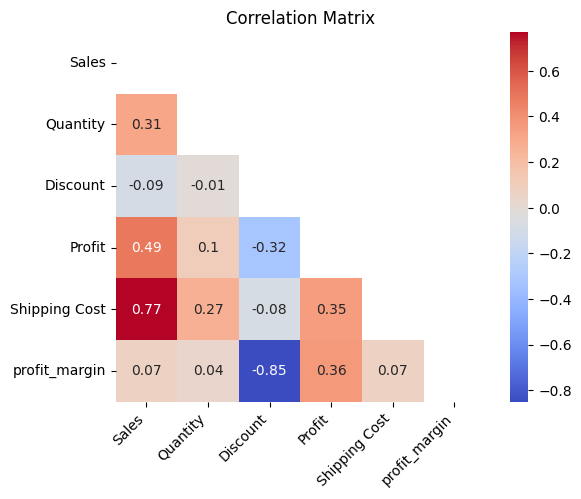

In [ ]:
# Correlation matrix
correlation_matrix = df.corr(numeric_only=True)
sns.heatmap(correlation_matrix.round(2), annot=True, cmap='coolwarm',
            mask=np.triu(correlation_matrix), square=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Matrix')

**Noticeable correlation**:
- (Sales and Profit):                 0.49 - moderate
- (Sales and Shipping Cost):          0.77 - strong
- (profit_margin and Discount):      -0.85 - strong




**These correlation may indicate that**:
- We can increase Profit by increase Sales
- Customer tend to require premium shipping service for high value product
- Discount impact Profit negatively


---> We will discover these relationships later

## 2.1 Overview of Revenue

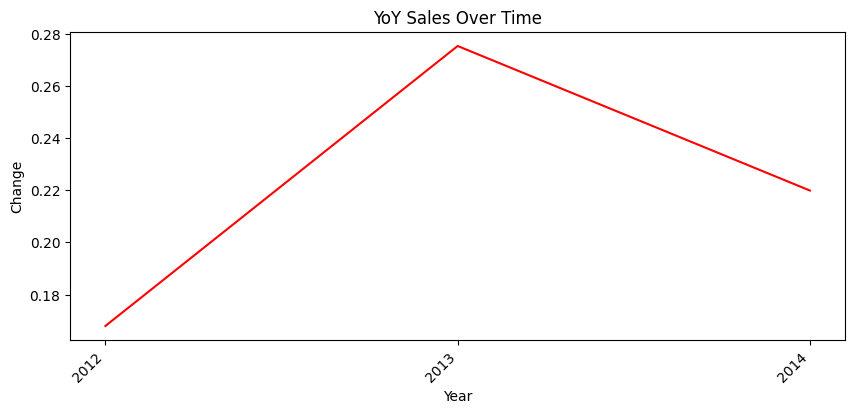

In [ ]:
# Calculate aggregate data by month
yearly = df.groupby('year').agg(
    Sales=('Sales', 'sum'),
    Profit=('Profit', 'sum')
).reset_index()
# Calculate margin
yearly['profit_margin'] = round(yearly['Profit']/yearly['Sales'], 4)
# Calculate MoM
yearly['mom_sale'] = round(yearly['Sales'].pct_change(), 4)
yearly['mom_profit'] = round(yearly['Profit'].pct_change(), 4)
# Plot
plt.figure(figsize=(10, 4))
sns.lineplot(x='year', y='mom_sale', data=yearly, color='red', ci=None)
plt.xlabel('Year')
plt.ylabel('Change')
plt.title('YoY Sales Over Time')
plt.xticks(rotation=45, ha='right')
plt.show()

Sale growth rate decrease in 2014. However this growth rate still better than other large competitor ([MWG: 14%](https://cdnv2.tgdd.vn/mwgvn/investorrelations/files/posts/2025/2/0/45/49/4549fa2b232edba1d0044bf7e0b3f3dd.pdf)). Let 's have a closer look at quarterly performance

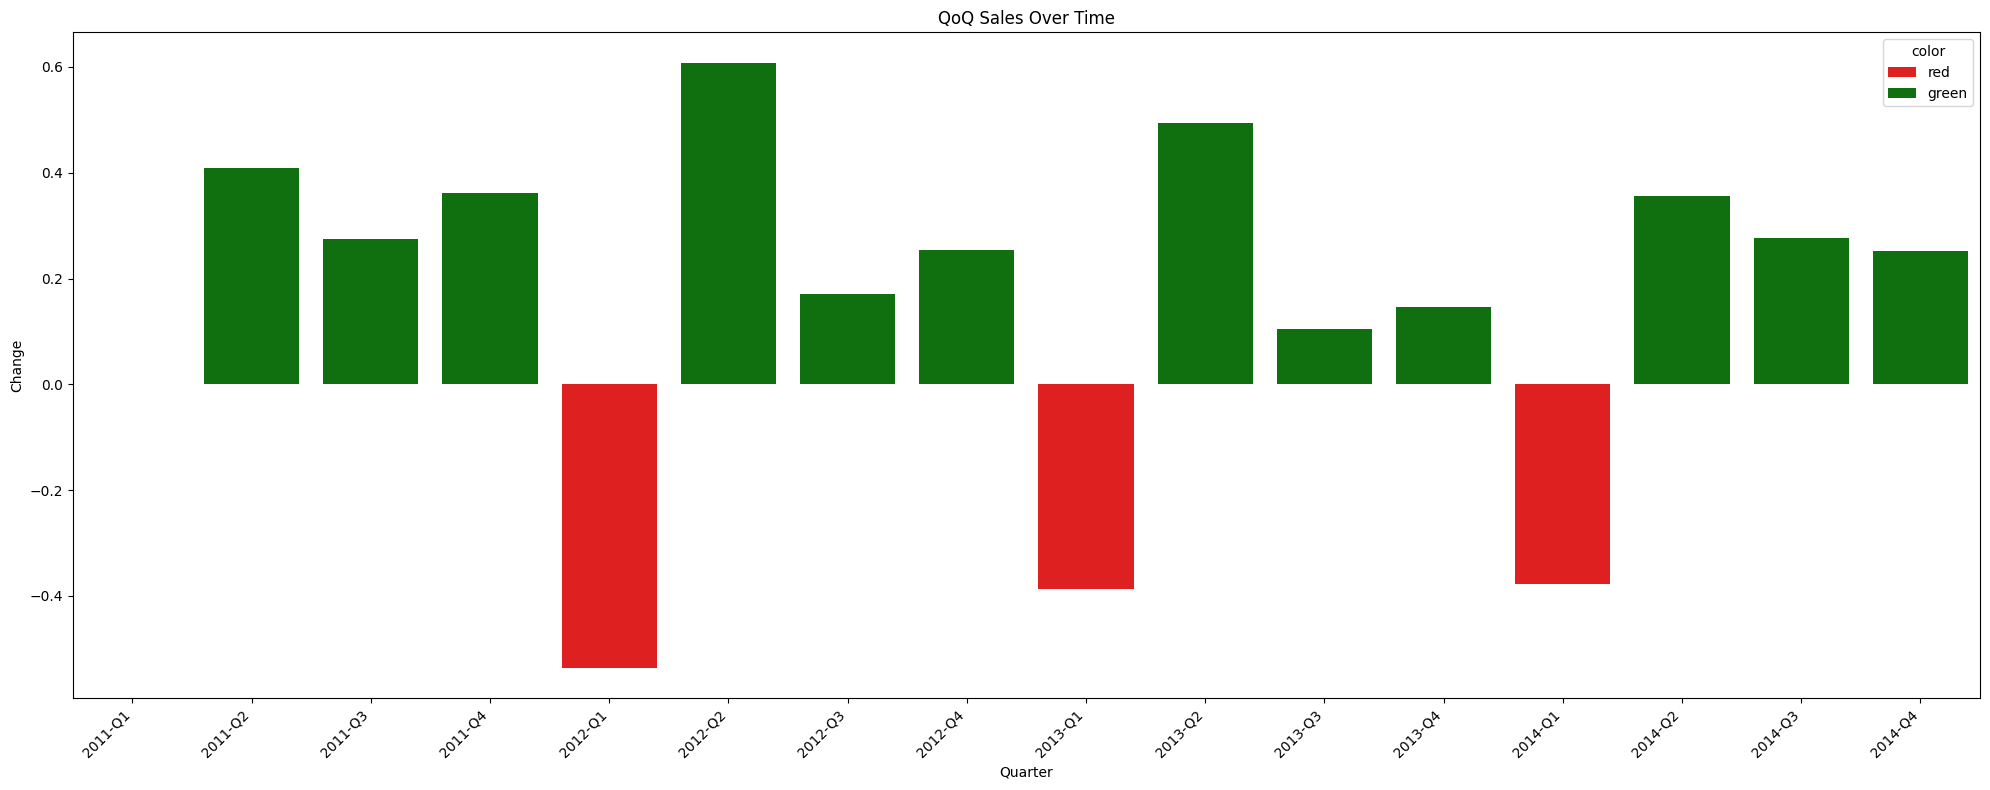

In [ ]:
# Calculate aggregate data by month
quarterly = df.groupby('quarter_year').agg(
    Sales=('Sales', 'sum'),
    Profit=('Profit', 'sum')
).reset_index()
# Calculate margin
quarterly['profit_margin'] = round(quarterly['Profit']/quarterly['Sales'], 4)
# Calculate MoM
quarterly['mom_sale'] = round(quarterly['Sales'].pct_change(), 4)
quarterly['mom_profit'] = round(quarterly['Profit'].pct_change(), 4)
# Plot
plt.figure(figsize=(20, 8))
quarterly['color'] = quarterly['mom_sale'].apply(lambda x: 'green' if x > 0 else 'red')
sns.barplot(x='quarter_year', y='mom_sale', data=quarterly, hue='color', dodge=False, palette=['red', 'green'], ci=None)
plt.xlabel('Quarter')
plt.ylabel('Change')
plt.title('QoQ Sales Over Time')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In each year, the first quarter always experience the dramatic drop in sale value, while other quarters' growth are positive. The second quarter has the largest growth (due to low base of previous quarter)

Average margin: 0.1166


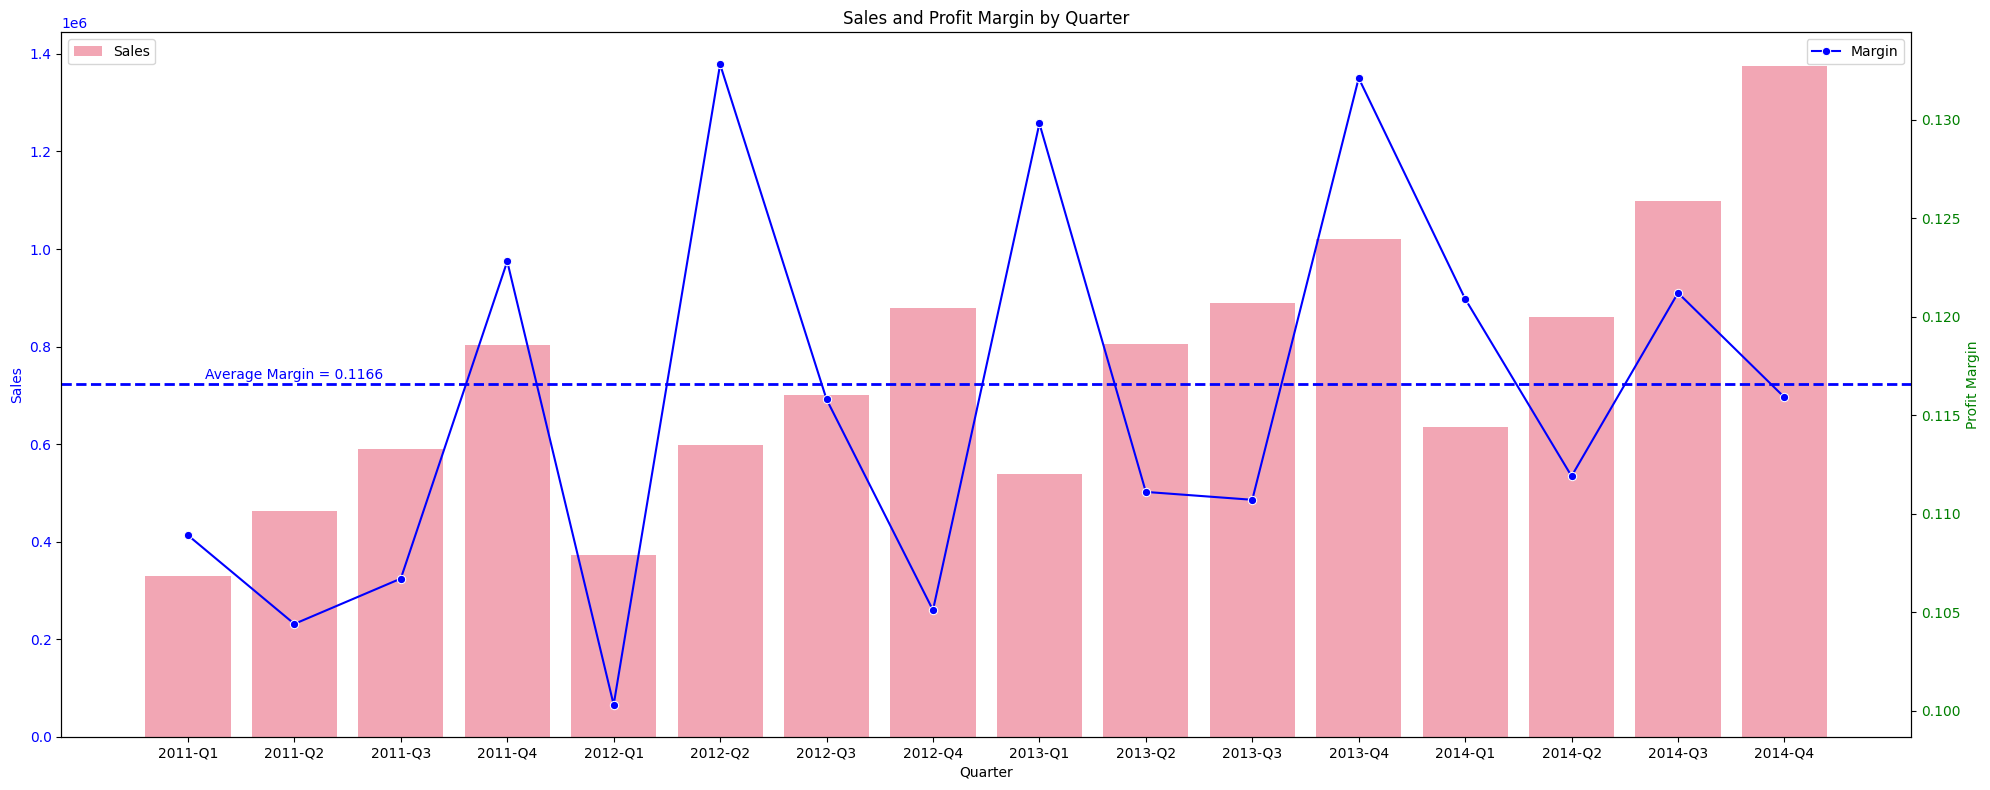

In [ ]:
# Average Margin over the dataset
average_margin = round(df['Profit'].sum() / df['Sales'].sum(), 4)

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(20, 8))

# Plot the bar chart for Sales
sns.barplot(x='quarter_year', y='Sales', data=quarterly, ax=ax1, color='#FF99AC', ci=None, label='Sales')
ax1.set_xlabel('Quarter')
ax1.set_ylabel('Sales', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# Create a second y-axis for the profit_margin line chart
ax2 = ax1.twinx()
sns.lineplot(x='quarter_year', y='profit_margin', data=quarterly, ax=ax2, color='blue', marker='o', ci=None, label='Margin')
ax2.set_ylabel('Profit Margin', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper right')

# Title and formatting
# Draw average margin line
plt.axhline(y=average_margin, color='b', linestyle='dashed', linewidth=2 )
plt.text(1, average_margin + 0.0001, f'Average Margin = {average_margin}', color='blue', va='bottom', ha='center')
print(f'Average margin: {average_margin}')
plt.title('Sales and Profit Margin by Quarter')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Revenue has seasonality pattern. For each year, sale is the lowest at the first quarter and increase gradually until the end of the year after dropping when move to the next year 's first quarter. However,
annual sale increases over years

In [ ]:
# Calculate aggregate data by month
monthly = df.groupby('month_year').agg(
    Sales=('Sales', 'sum'),
    Profit=('Profit', 'sum')
).reset_index()
# Calculate margin
monthly['profit_margin'] = round(monthly['Profit']/monthly['Sales'], 4)

# Calculate MoM
monthly['mom_sale'] = round(monthly['Sales'].pct_change(), 4)
monthly['mom_profit'] = round(monthly['Profit'].pct_change(), 4)

monthly.head()

month_year         Sales       Profit  profit_margin  mom_sale  mom_profit
0    2011-01   94014.99136   7888.20346         0.0839       NaN         NaN
1    2011-02   89664.21848  12287.34848         0.1370   -0.0463      0.5577
2    2011-03  145115.69336  15620.31426         0.1076    0.6184      0.2713
3    2011-04  111098.36818  13078.14838         0.1177   -0.2344     -0.1627
4    2011-05  142541.69410  12585.57570         0.0883    0.2830     -0.0377

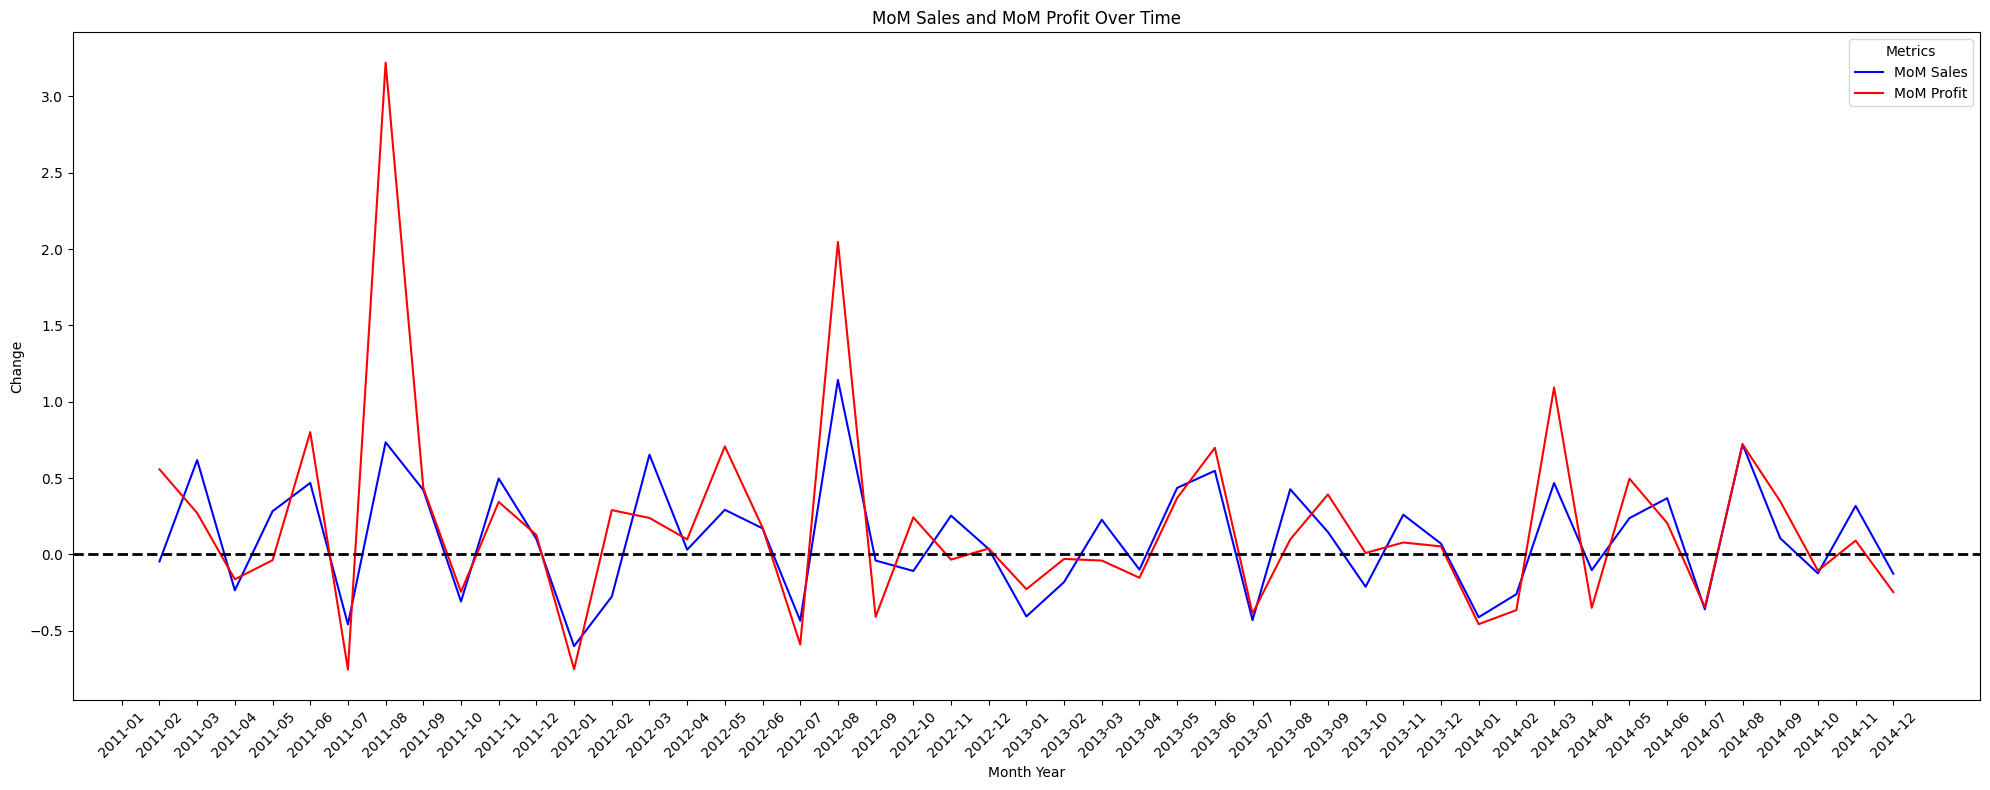

In [ ]:
plt.figure(figsize=(20, 8))
# Plot Sales as a line chart
sns.lineplot(x='month_year', y='mom_sale', data=monthly, label='MoM Sales', color='blue', ci=None)
sns.lineplot(x='month_year', y='mom_profit', data=monthly, label='MoM Profit', color='red', ci=None)
plt.axhline(y=0, color='black', linestyle='dashed', linewidth=2 )

plt.xlabel('Month Year')
plt.ylabel('Change')
plt.title('MoM Sales and MoM Profit Over Time')
plt.legend(title='Metrics')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- MoM of Profit and MoM of Sales tend to fluctuate together. However, MoM of Profit has higher variance
- MoM Profit has 3 times larger than 1, while MoM Sales has 1 times
- They once peaked at the same time at 08/2012

Let's look more closely at those months

In [ ]:
monthly[['month_year', 'mom_profit', 'mom_sale']].sort_values(by='mom_profit', ascending=False).head(3)

month_year  mom_profit  mom_sale
7     2011-08      3.2210    0.7346
19    2012-08      2.0467    1.1435
38    2014-03      1.0936    0.4681

We will explore why MoM Profit are peak at those 3 months. And why MoM Sales peak at the same time in 08.2012

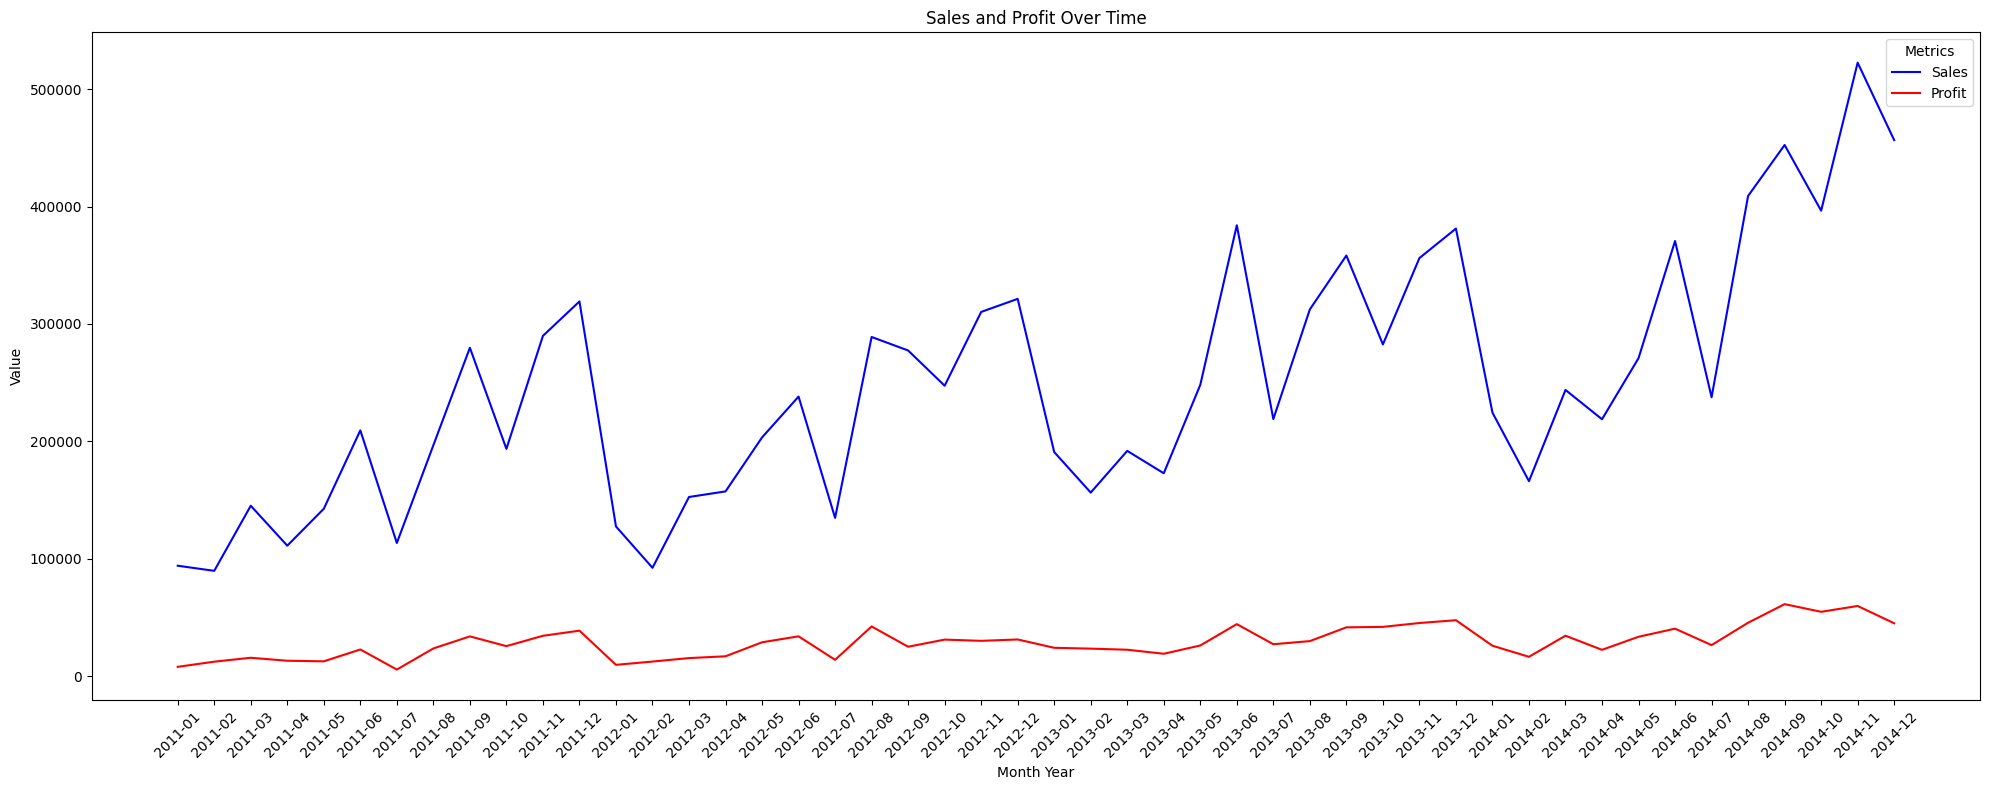

In [ ]:
plt.figure(figsize=(20, 8))
# Plot Sales as a line chart
sns.lineplot(x='month_year', y='Sales', data=monthly, label='Sales', color='blue', ci=None)
sns.lineplot(x='month_year', y='Profit', data=monthly, label='Profit', color='red', ci=None)

plt.xlabel('Month Year')
plt.ylabel('Value')
plt.title('Sales and Profit Over Time')
plt.legend(title='Metrics')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Dive deeper in the value change, we figure out that those 3 months with highest MoM are all grow from low base of previous month

**Summary of Over of Revenue**
*   Sale growth decrease in 2014
*   Sale has a seasonal pattern
*   Outstanding growth period-over-period is mainly due to previous low base





## 2.2 Order

### 2.2.1 Overview of Orders

In [ ]:
# Create some date-related columns for later time-intelligence analysis
order['year'] = order['Order Date'].dt.year.astype(str)
order['month_name'] = order['Order Date'].dt.month_name()
order['week_number'] = order['Order Date'].dt.isocalendar().week.astype(str)
order['day_of_week'] = order['Order Date'].dt.day_name()
order['quarter'] = order['Order Date'].dt.quarter.astype(str)
order['quarter_year'] = order['Order Date'].dt.year.astype(str) + '-Q' + order['Order Date'].dt.quarter.astype(str)
order['month_year'] = order['Order Date'].dt.year.astype(str) + '-' + order['Order Date'].dt.month.astype(str).str.zfill(2)
order['week_year'] = order['Order Date'].dt.year.astype(str) + '-W' + order['Order Date'].dt.isocalendar().week.astype(str).str.zfill(2)
order.head()

Order ID Order Date  Ship Date Customer ID    Segment  \
0  AE-2011-9160 2011-10-03 2011-10-07     PO-8865   Consumer   
1  AE-2013-1130 2013-10-14 2013-10-14     EB-4110   Consumer   
2  AE-2013-1530 2013-12-31 2014-01-03     MY-7380  Corporate   
3  AE-2014-2840 2014-11-05 2014-11-08     PG-8820   Consumer   
4  AE-2014-3830 2014-12-13 2014-12-19     GH-4665   Consumer   

                Country Market Region       Ship Mode Order Priority    Sales  \
0  United Arab Emirates   EMEA   EMEA  Standard Class         Medium  161.082   
1  United Arab Emirates   EMEA   EMEA        Same Day           High  228.996   
2  United Arab Emirates   EMEA   EMEA    Second Class           High   23.634   
3  United Arab Emirates   EMEA   EMEA     First Class       Critical   42.480   
4  United Arab Emirates   EMEA   EMEA  Standard Class         Medium  281.502   

   Quantity   Profit  Shipping Cost  year month_name week_number day_of_week  \
0         8 -246.078           9.56  2011    October          40      Monday   
1         7 -236.964          60.18  2013    October          42      Monday   
2         3  -38.076           3.16  2013   December           1     Tuesday   
3         1  -75.060           8.04  2014   November          45   Wednesday   
4        16 -429.108          19.38  2014   December          50    Saturday   

  quarter quarter_year month_year week_year  
0       4      2011-Q4    2011-10  2011-W40  
1       4      2013-Q4    2013-10  2013-W42  
2       4      2013-Q4    2013-12  2013-W01  
3       4      2014-Q4    2014-11  2014-W45  
4       4      2014-Q4    2014-12  2014-W50

In [ ]:
# Feature engineering
# Create "days_of_shipment" calculate the difference between Order Date and Ship Date
order['days_of_shipment'] = (order['Ship Date'] - order['Order Date']).dt.days

# Create "profit_margin" to calculate profitability
order['profit_margin'] = order['Profit'] / order['Sales']

In [ ]:
# Creating a function a iterate over each column and plot histogram
def histogram_for_df(df, rows, cols, figsize):
    """
    Plots histograms with mean and median lines for each numeric column in the DataFrame.

    Args:
    - df: The DataFrame containing the data.
    - rows: Number of rows in the subplot grid.
    - cols: Number of columns in the subplot grid.
    - figsize: Tuple representing the figure size.
    """

    # Create subplots with the specified number of rows and columns
    fig, axes = plt.subplots(rows, cols, figsize=figsize)

    # Flatten the axes array into a 1D array
    axes = axes.flatten()

    # Iterate over columns to create histograms
    for i, col in enumerate(df.columns):
        sns.histplot(df[col], ax=axes[i], color='#FF99AC')
        axes[i].set_title(col)
        axes[i].tick_params(axis='x', labelrotation=45, labelleft=True)

        # Set the x-axis labels' horizontal alignment to 'right'
        for label in axes[i].get_xticklabels():
            label.set_ha('right')

        if np.issubdtype(df[col].dtype, np.number):
            # Calculate mean and median
            mean_val = df[col].mean()
            median_val = df[col].median()

            # Plot mean and median lines
            axes[i].axvline(mean_val, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_val:.2f}')
            axes[i].axvline(median_val, color='blue', linestyle='solid', linewidth=1, label=f'Median: {median_val:.2f}')

            # Add the legend
            axes[i].legend()

        # Handle cases where there are fewer subplots than columns
        if i >= rows * cols:
            break

    # Adjust spacing for better visualization
    plt.tight_layout()
    plt.show()

Let 's look at Order in some point of views

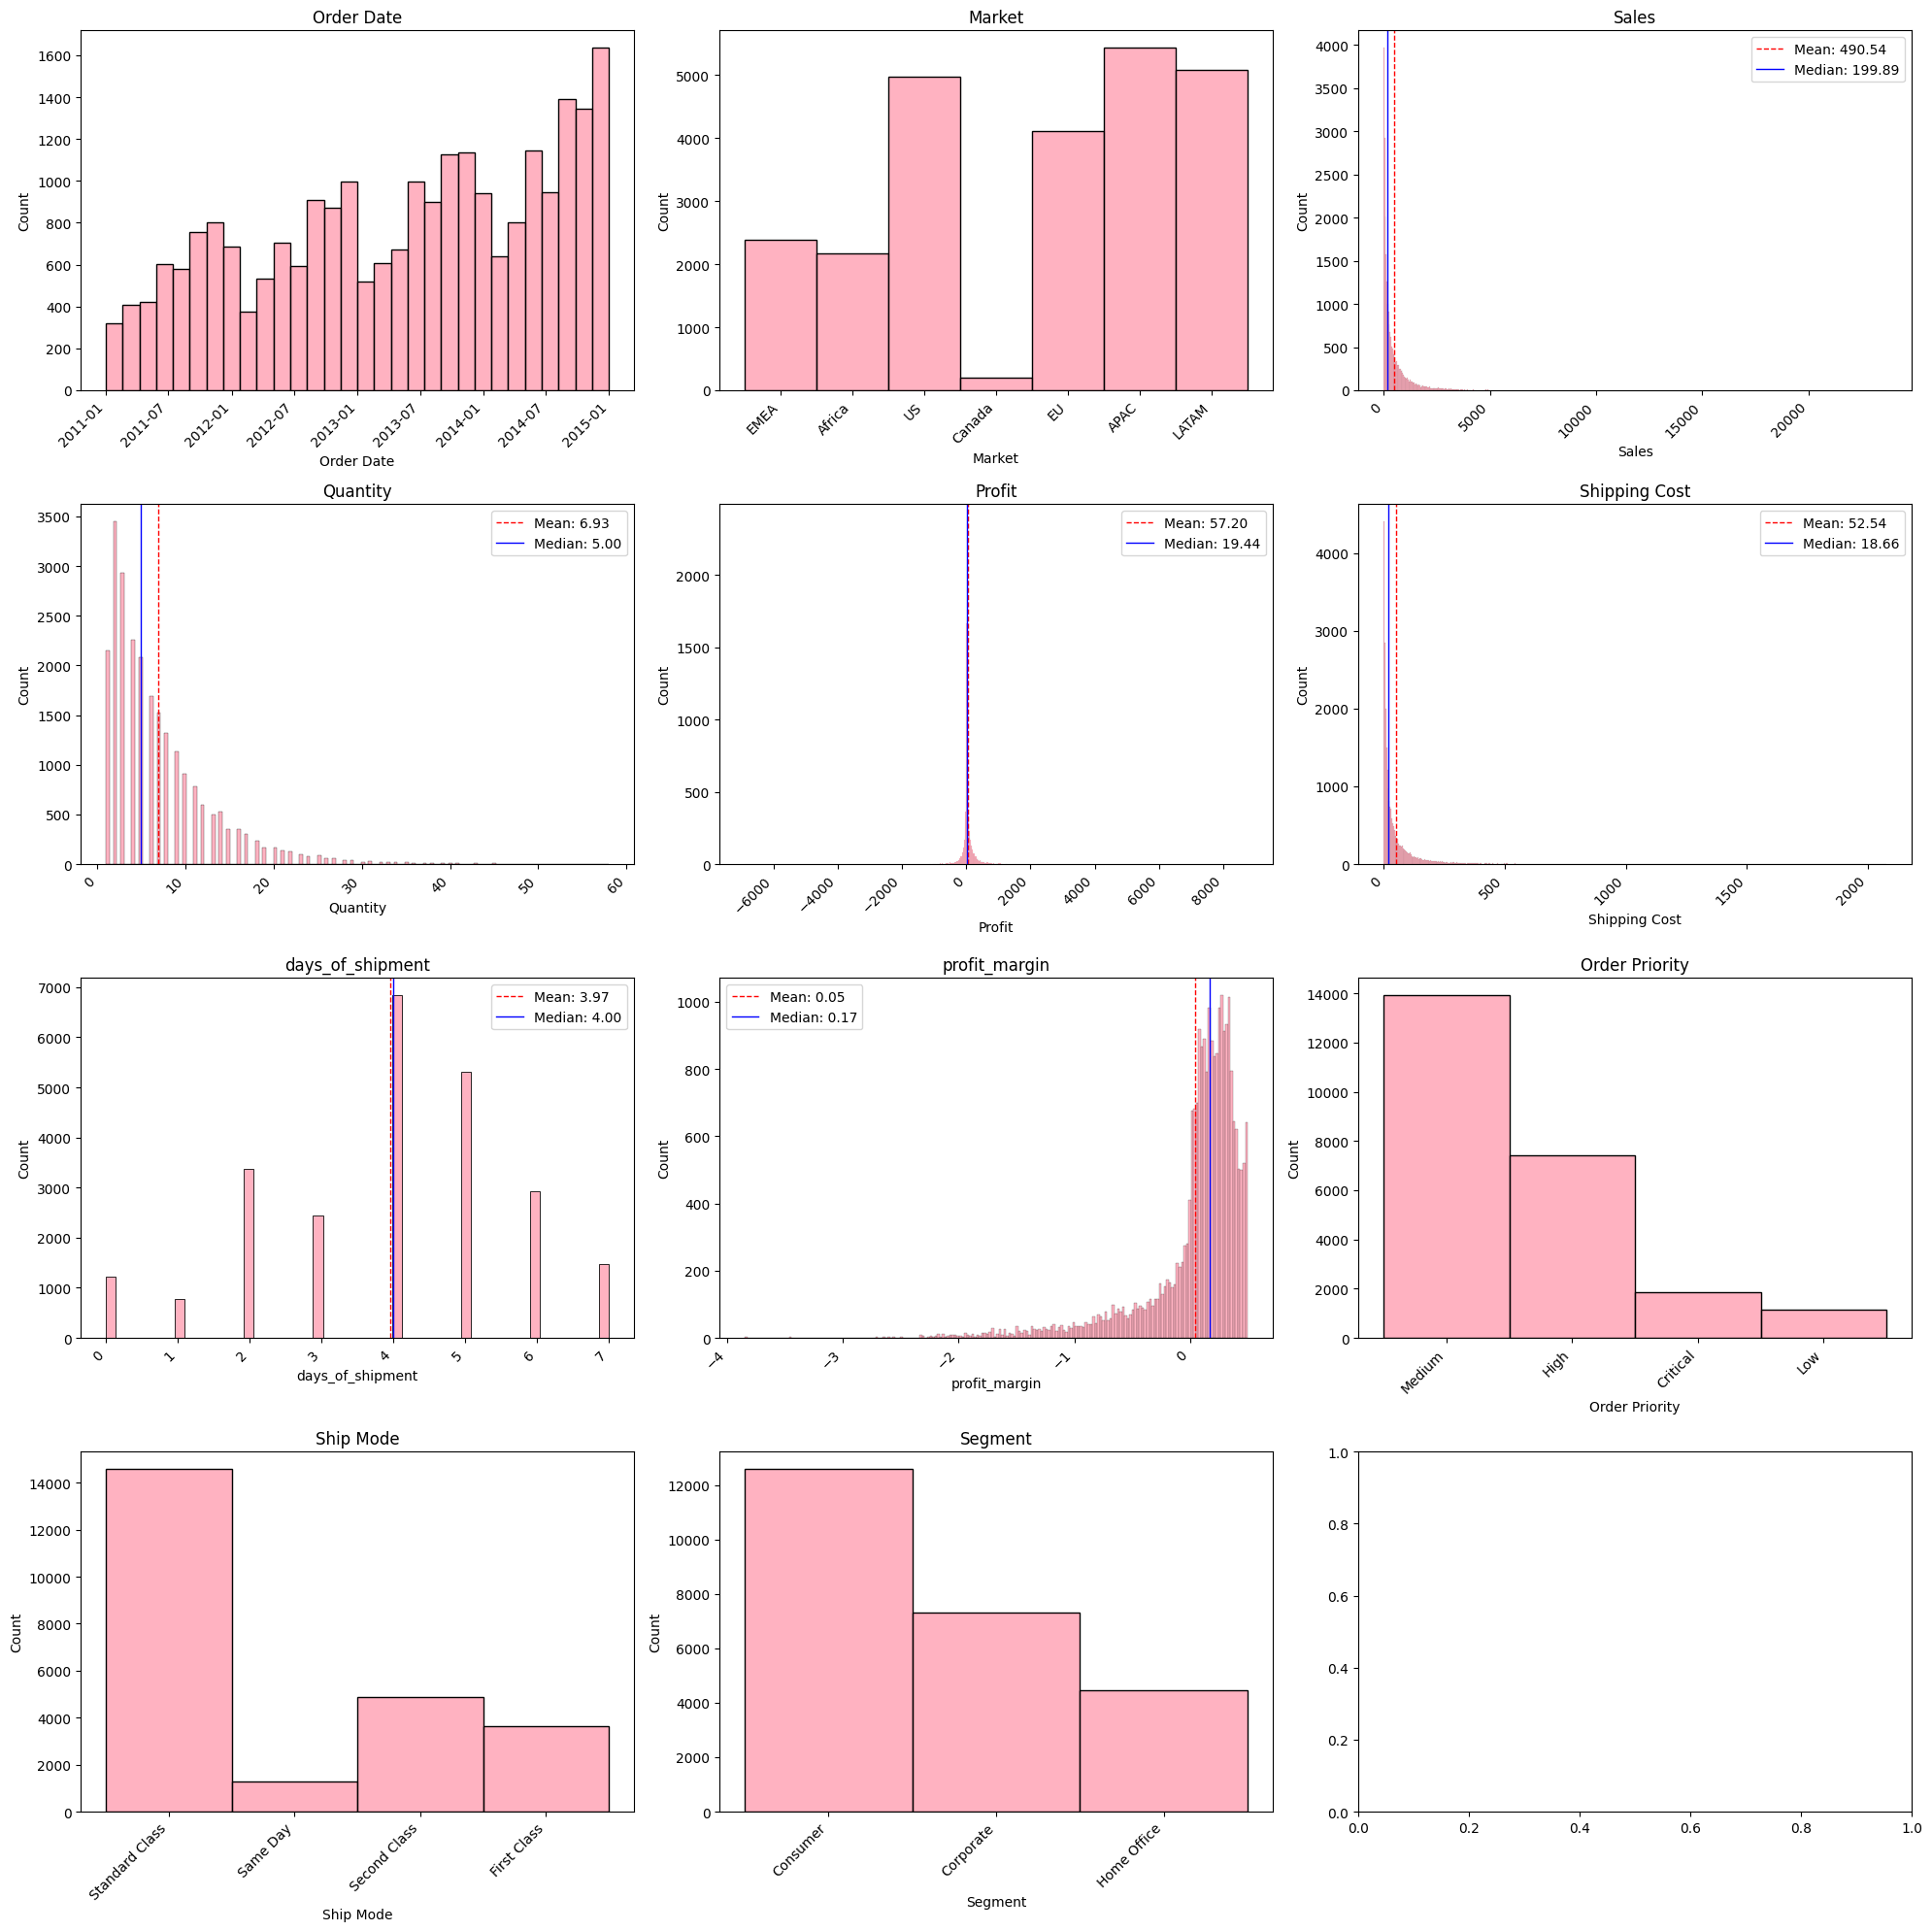

In [ ]:
histogram_for_df(order[['Order Date', 'Market', 'Sales', 'Quantity', 'Profit', 'Shipping Cost', 'days_of_shipment', 'profit_margin', 'Order Priority', 'Ship Mode', 'Segment']], 4, 3, (20, 20))

Insights from the plot

*   Order Date: There are seasonal trends, orders were low at the beginning of the year, and gradually increase until the end of the year
*   Quantity, Sales, Shipping Cost are skewd heavily
*   Profit has a large variance, with some orders are extreme profit while other are sold at loss. In the Product Analysis part, we will discover why company are selling products at loss
*   Medium (Order Priority), Standard Class (Ship Mode) have the largest number of order. This indicates that most customers prefer standard service
*   US is one of the largest market, with the number of orders are nearly equal to big region like APAC, and LATAM
*   Quantity: Most orders contain 1 to 5 items
*   days_of_shipment: the average time is 4 days









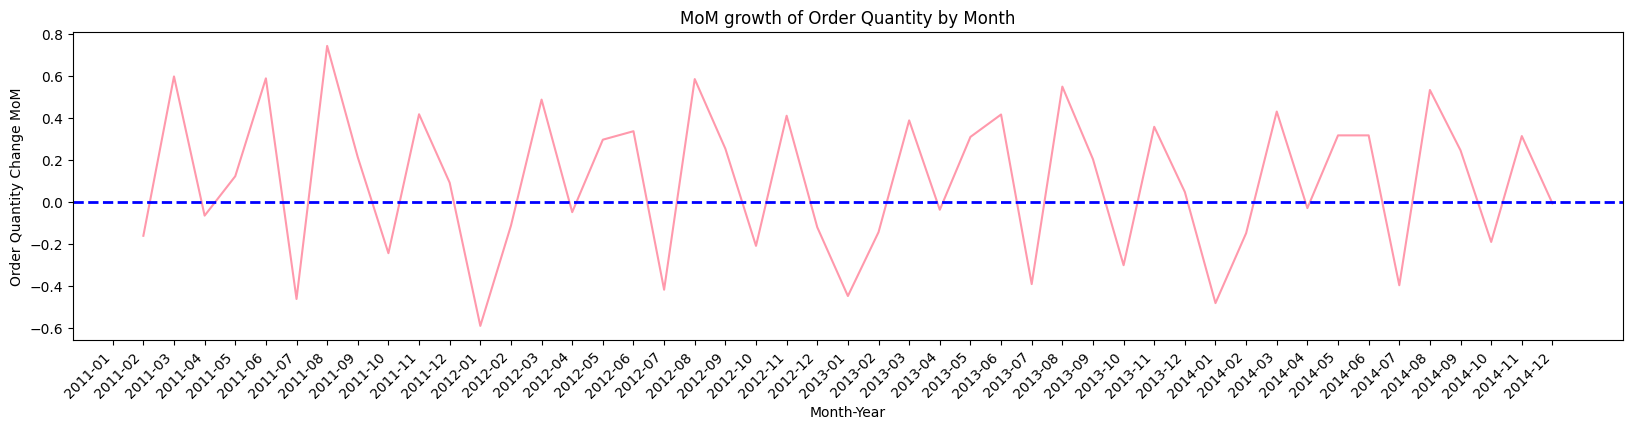

In [ ]:
# Calculate MoM growth of Order Quantity by Month
monthly_order = order.groupby('month_year').agg(
    order_quantity = ('Order ID', 'count'),
    total_sales = ('Sales', 'sum')
).reset_index()
monthly_order['MoM Growth'] = round(monthly_order['order_quantity'].pct_change(), 4)

# Plot
plt.figure(figsize=(20, 4))
sns.lineplot(x=monthly_order['month_year'], y=monthly_order['MoM Growth'], color='#FF99AC', ci=None)
plt.title('MoM growth of Order Quantity by Month')
plt.xlabel('Month-Year')
plt.ylabel('Order Quantity Change MoM')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=0, color='b', linestyle='dashed', linewidth=2 )
plt.show()

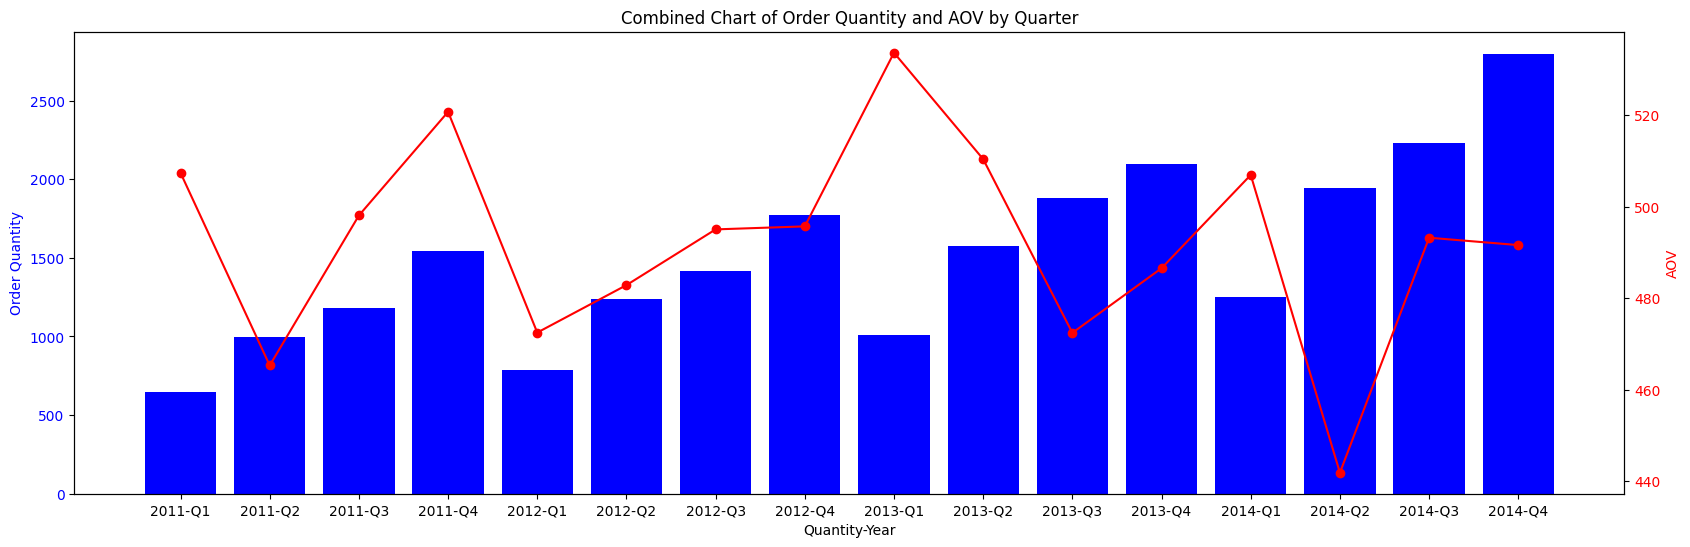

In [ ]:
# Calcualte AOV and Order Quantity for each quarter
quarterly_order = order.groupby('quarter_year').agg(
    order_quantity = ('Order ID', 'count'),
    total_sales = ('Sales', 'sum')
).reset_index()
quarterly_order['aov'] = quarterly_order['total_sales'] / quarterly_order['order_quantity']

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(20, 6))
ax1.bar(quarterly_order['quarter_year'], quarterly_order['order_quantity'], color='b', label='Order Quantity')
ax1.set_xlabel('Quantity-Year')
ax1.set_ylabel('Order Quantity', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis (twin axis) for the line chart
ax2 = ax1.twinx()
ax2.plot(quarterly_order['quarter_year'], quarterly_order['aov'], color='r', label='AOV', marker='o')
ax2.set_ylabel('AOV', color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.title('Combined Chart of Order Quantity and AOV by Quarter')

# Show the plot
plt.show()

While the order quantity increase quarterly, the AOV show a downward trend.

**Summary of Overview of Order**
- Most orders use basic service: Medium (order priority), Standard Class (ship mode)
- While order quantity grows over time, AOV show a downward trend
- Some orders are sold at lost


### 2.2.2 Time of Order




We have discovered the seasonality trend in the order quantity in previous session. Let's look at this trend in detail

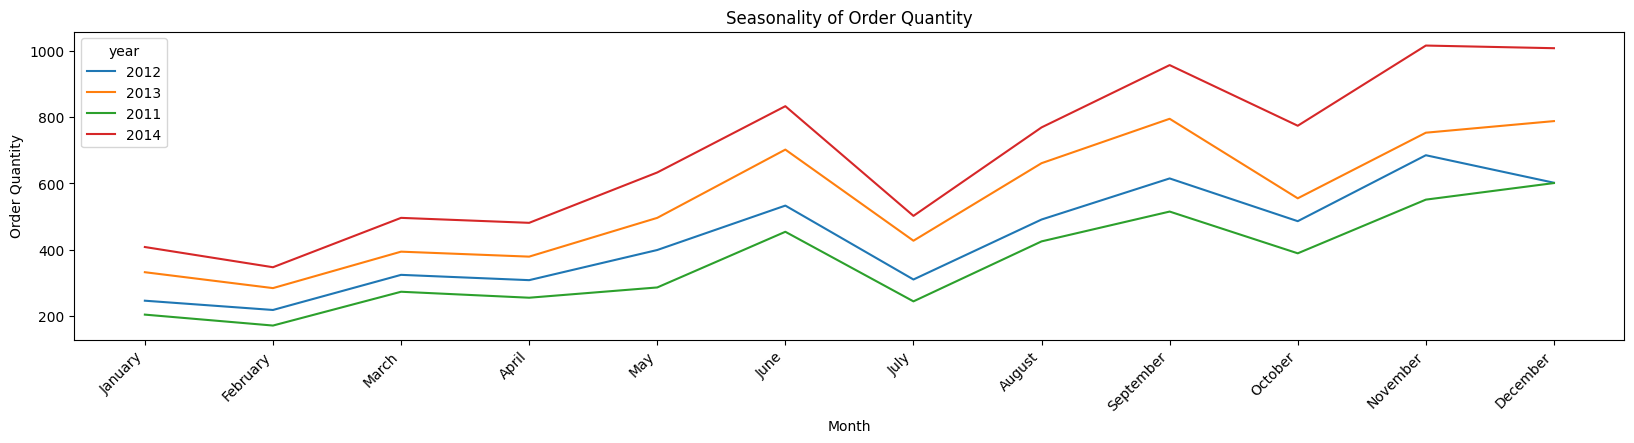

In [ ]:
seasonal_pattern = order.groupby(['year', 'month_name'])['Order ID'].count().reset_index()
# Ensure the 'month_name' column has the correct month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
seasonal_pattern['month_name'] = pd.Categorical(seasonal_pattern['month_name'], categories=month_order, ordered=True)
seasonal_pattern = seasonal_pattern.sort_values('month_name')
# Plot
plt.figure(figsize=(20, 4))
sns.lineplot(x=seasonal_pattern['month_name'], y=seasonal_pattern['Order ID'], hue=seasonal_pattern['year'])
plt.title('Seasonality of Order Quantity')
plt.xlabel('Month')
plt.ylabel('Order Quantity')
plt.xticks(rotation=45, ha='right')
plt.show()

Wow!!! The seasonal patterns are exactly the same for 4 years. The order quantity increase, and decrease at the same time for all years.

-->This will help us a lot is optimize inventory and predict demand. Later, we will leverage this to build a predictive model

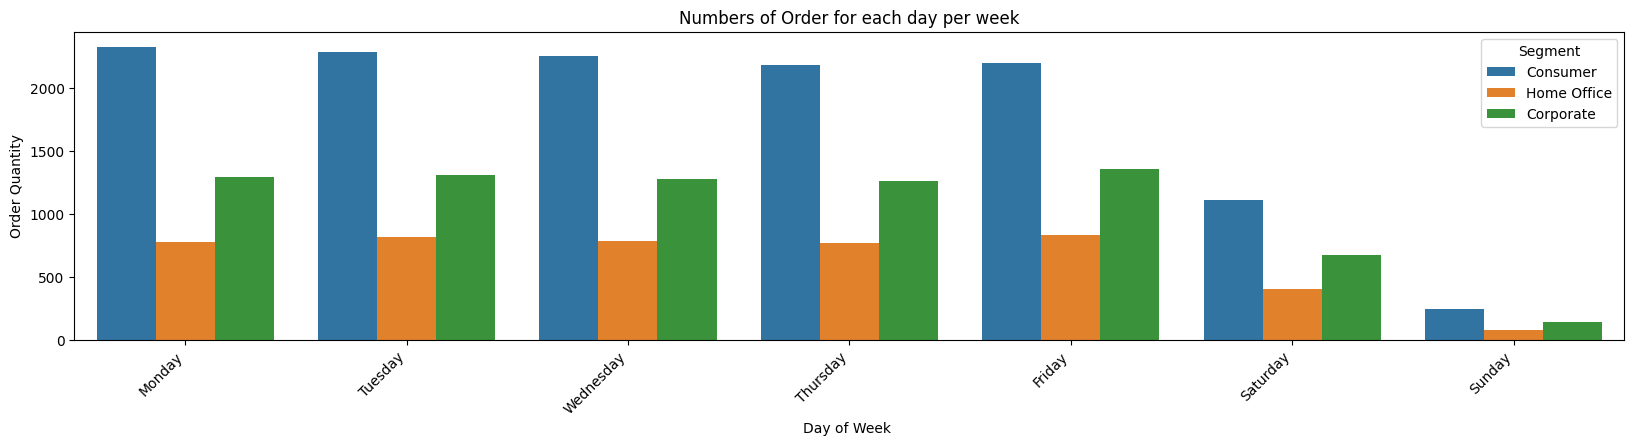

In [ ]:
day_of_week = order.groupby(['Segment', 'day_of_week'])['Order ID'].count().reset_index()
day_of_week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Get day_of_week to display in right order
day_of_week['day_of_week'] = pd.Categorical(day_of_week['day_of_week'], categories=day_of_week_order, ordered=True)
day_of_week = day_of_week.sort_values('day_of_week')
# Plot
plt.figure(figsize=(20, 4))
sns.barplot(x=day_of_week['day_of_week'], y=day_of_week['Order ID'], hue=day_of_week['Segment'])
plt.title('Numbers of Order for each day per week')
plt.xlabel('Day of Week ')
plt.ylabel('Order Quantity')
plt.xticks(rotation=45, ha='right')
plt.show()

The number of orders are similar from Monday to Friday but reduce significantly at the weekend for all customer segment.

In [ ]:
# Calculate time between two consecutive orders
reorder = order[['Customer ID', 'Order ID', 'Order Date']].sort_values(by=['Customer ID', 'Order Date'])
# Calculate the time difference from the previous order for each customer
reorder['Time from Previous Order'] = reorder.groupby('Customer ID')['Order Date'].diff().fillna(pd.Timedelta(0))
reorder['Time from Previous Order (days)'] = reorder['Time from Previous Order'].dt.days
# Next exclude the first order
reorder_no_first = reorder.groupby('Customer ID').apply(lambda x: x.iloc[1:]).reset_index(drop=True)
reorder_no_first.head()


Customer ID         Order ID Order Date Time from Previous Order  \
0    AA-10315    ID-2011-40953 2011-07-04                  95 days   
1    AA-10315   CA-2011-138100 2011-09-15                  73 days   
2    AA-10315   MX-2011-114685 2011-11-24                  70 days   
3    AA-10315  ES-2012-2960821 2012-05-16                 174 days   
4    AA-10315   CA-2012-121391 2012-10-04                 141 days   

   Time from Previous Order (days)  
0                               95  
1                               73  
2                               70  
3                              174  
4                              141

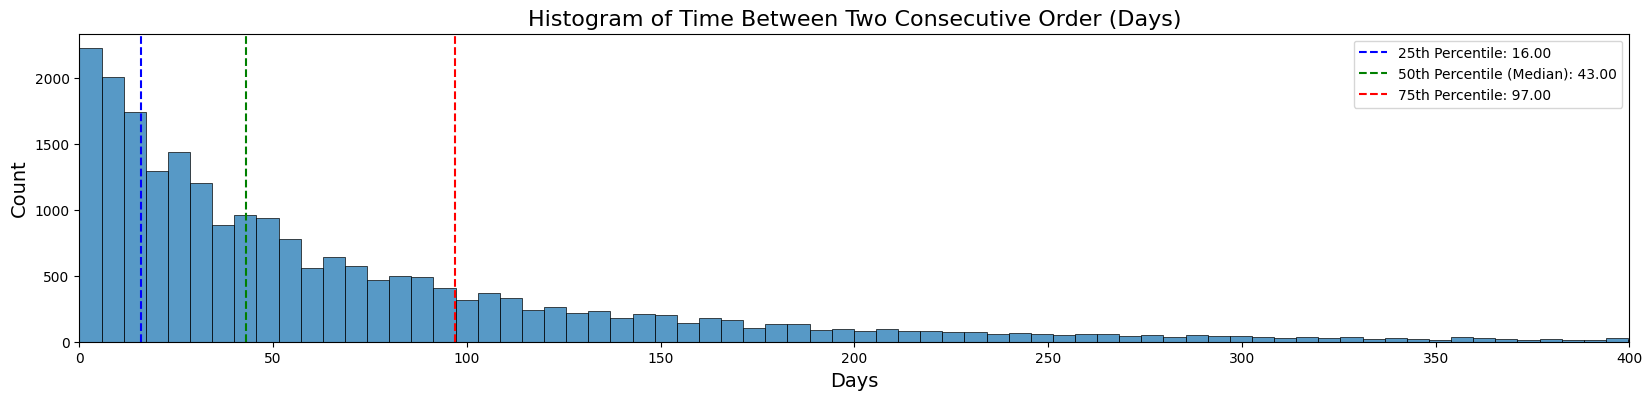

In [ ]:
# Calculate the quantiles
q25 = np.percentile(reorder_no_first['Time from Previous Order (days)'], 25)
q50 = np.percentile(reorder_no_first['Time from Previous Order (days)'], 50)
q75 = np.percentile(reorder_no_first['Time from Previous Order (days)'], 75)

# Create the plot
plt.figure(figsize=(20, 4))
sns.histplot(reorder_no_first['Time from Previous Order (days)'], kde=False)
plt.axvline(q25, color='blue', linestyle='--', label=f'25th Percentile: {q25:.2f}')
plt.axvline(q50, color='green', linestyle='--', label=f'50th Percentile (Median): {q50:.2f}')
plt.axvline(q75, color='red', linestyle='--', label=f'75th Percentile: {q75:.2f}')

# Add title and labels
plt.title('Histogram of Time Between Two Consecutive Order (Days)', fontsize=16)
plt.xlabel('Days', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlim(0, 400)
plt.legend()
plt.show()


*   Customer are usually make the next order 16 to 97 days after previous order


*   25% order happens after 16 days from previous order. Specifically, 0-5 days is the largest group --> This indicates that customesr tend to buy new order soon after they finished the existing one. Company can recommend customer new product with discount to incentivize they make new order after finished existing one.



*   Note: The max of time from previous day are around 1200, but I just display x from 0 to 400 only so that we can see clearer most data points



**Summary of Time of Order**
- Order Quantity shows an exact seasonal pattern for each year (increase and decrease at the same time for all year with relatively simmilar magnitude)
- Order Quantity are similar at weekday, but drop significantly at weekend for all customer segment
- Re-order tend to happen soon after purchase. 25% reorder happened after 16 days, 50% happened after 43 days


### 2.2.3 Shipment

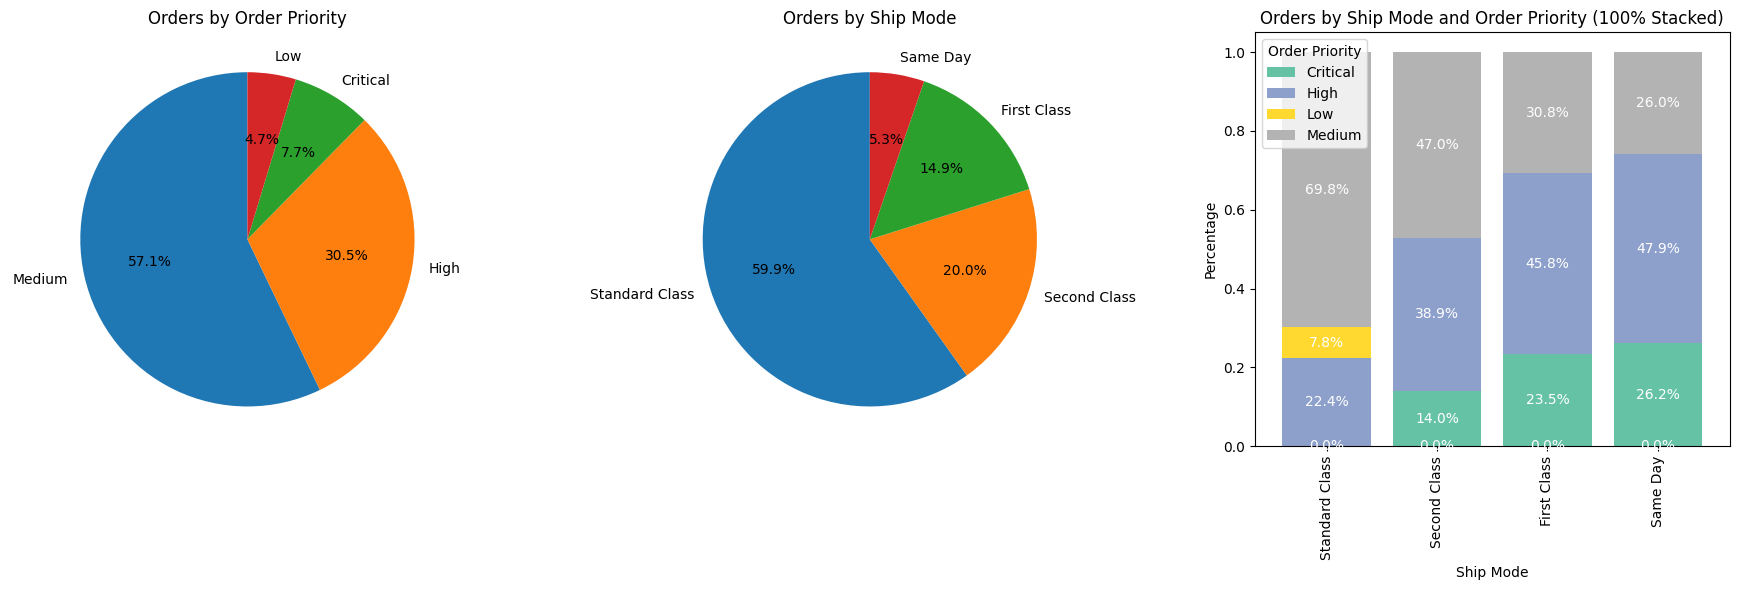

In [ ]:
# Grouping by Order Priority and Ship Mode to get counts
order_priority = order.groupby('Order Priority')['Order ID'].count().sort_values(ascending=False)
ship_mode = order.groupby('Ship Mode')['Order ID'].count().sort_values(ascending=False)

# 100% Stacked Bar chart data preparation
order_priority_by_ship_mode = order.groupby(['Ship Mode', 'Order Priority'])['Order ID'].count().unstack(fill_value=0)

# Sort the 'Ship Mode' categories in the custom order
ship_mode_order = ['Standard Class', 'Second Class', 'First Class', 'Same Day']
order_priority_by_ship_mode = order_priority_by_ship_mode.loc[ship_mode_order]

# Create the subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Pie chart for Order Priority
axes[0].pie(order_priority, labels=order_priority.index, autopct='%1.1f%%', startangle=90)
axes[0].axis('equal')
axes[0].set_title('Orders by Order Priority')

# Pie chart for Ship Mode
axes[1].pie(ship_mode, labels=ship_mode.index, autopct='%1.1f%%', startangle=90)
axes[1].axis('equal')
axes[1].set_title('Orders by Ship Mode')

# 100% Stacked Bar chart for Ship Mode and Order Priority
order_percentage = order_priority_by_ship_mode.div(order_priority_by_ship_mode.sum(axis=1), axis=0)

# Plot the stacked bar chart
order_percentage.plot(kind='bar', stacked=True, ax=axes[2], colormap='Set2', width=0.8)

# Add percentage annotations to the bars
for p in axes[2].patches:
    height = p.get_height()
    width = p.get_width()
    x, y = p.get_xy()  # Get position of the rectangle
    percentage = height * 100  # Convert height to percentage
    axes[2].text(x + width / 2, y + height / 2, f'{percentage:.1f}%', ha='center', va='center', color='white', fontsize=10)

# Set title and labels
axes[2].set_title('Orders by Ship Mode and Order Priority (100% Stacked)')
axes[2].set_ylabel('Percentage')
axes[2].set_xlabel('Ship Mode')

plt.tight_layout()
plt.show()


Pie chart
*   Medium (Ship Mode) and Standard Class (Order Priority) get the majority of orders.   -->   For the most of time, orders use standard service.
*   As the service advances from the standard service, the percentage of order get lower and lower (Medium > High > Critical, Standard > Second > First)   -->
  Premium service are expensive and unnecessary for most of orders

100% stacked bar chart


*   As the Ship Mode get more premium, the low quality service for Order Priority (Low and Medium) decrease or disappear. While the high quality (High or Critical) increase)   -->   Strong positive relationship between Ship Mode and Order Priority. Customer demand for premium Ship Mode tend to also demand premium Order Priority and vice versa





In [ ]:
# Create a function to create stacked bar chart stack by days_of_shipment
def stack_shipment(ax, stack, df=order):
    # Group and count days of shipment per stack (e.g., 'Ship Mode')
    result = df.groupby([stack, 'days_of_shipment']).agg({'days_of_shipment': 'count'}).rename(columns={'days_of_shipment': 'Count'}).reset_index()

    # Pivot the table to make days_of_shipment as columns, so that we can stack them
    result_pivot = result.pivot(index=stack, columns='days_of_shipment', values='Count').fillna(0)

    # Plotting a stacked bar on the provided axis
    result_pivot.plot(kind='bar', stacked=True, ax=ax, colormap='coolwarm')

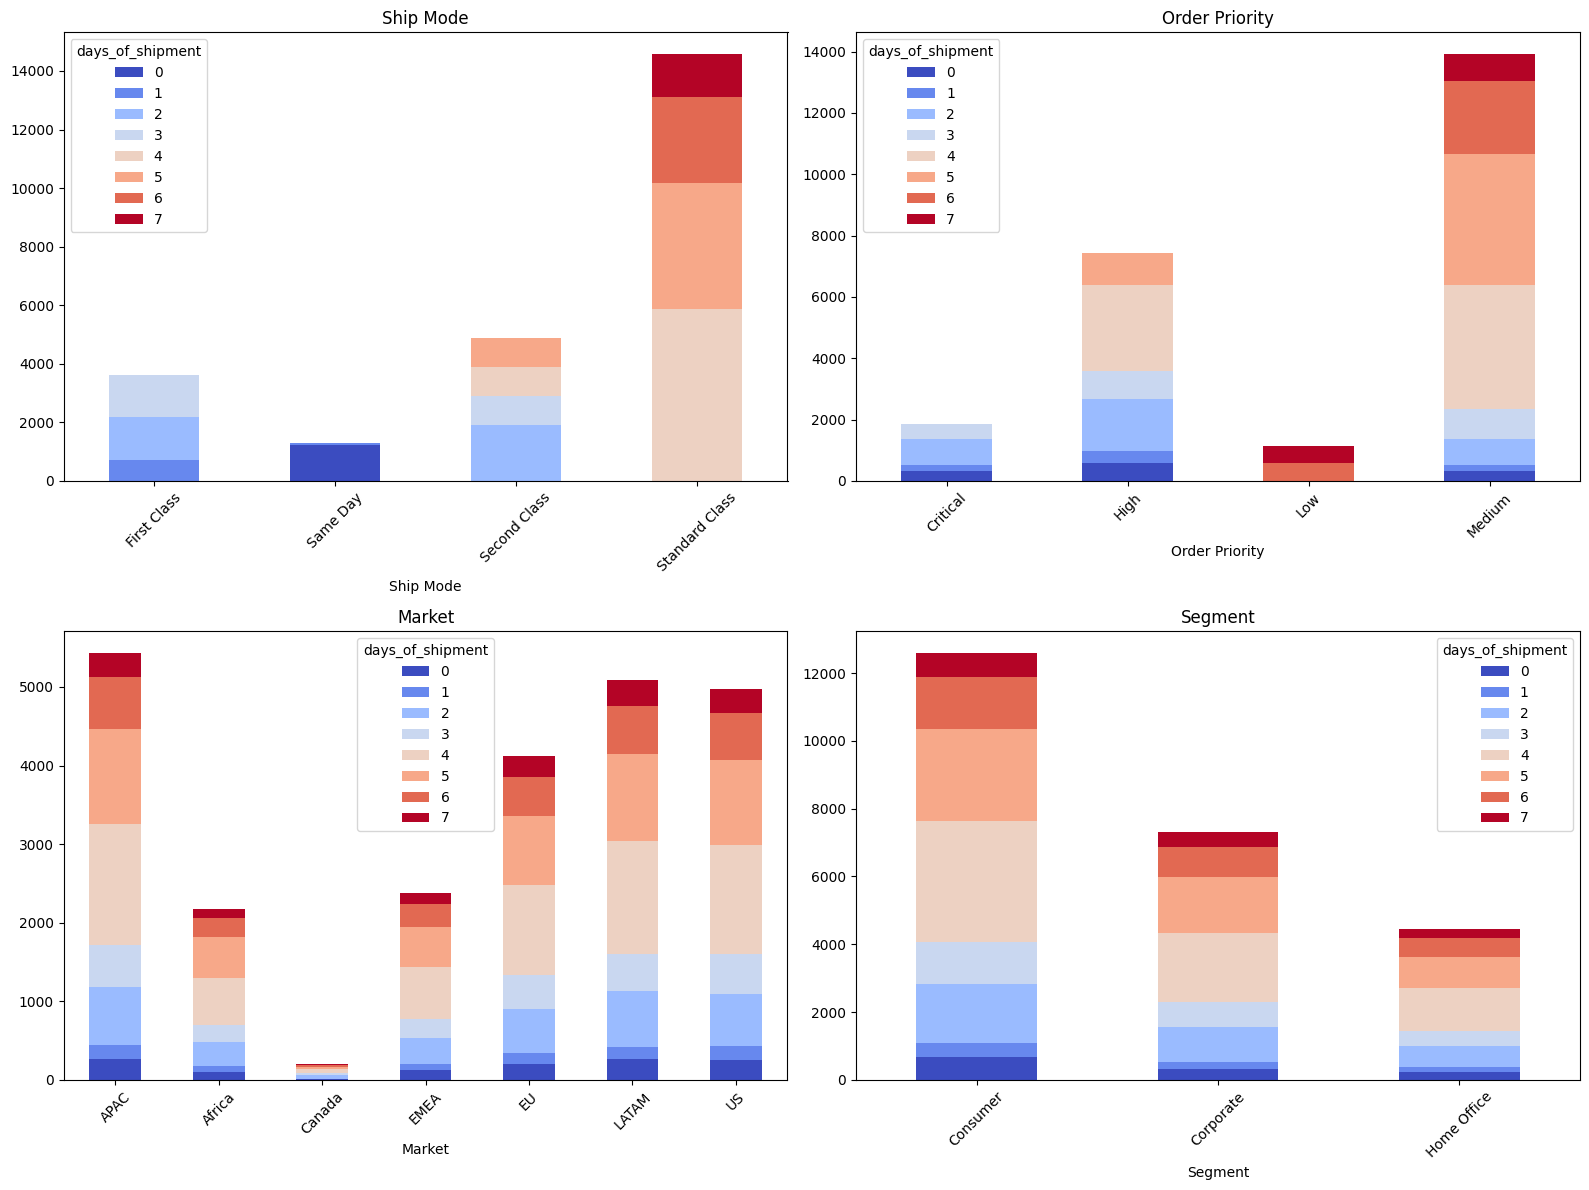

In [ ]:
# Create subplot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
# Flatten the 2D axes array into a 1D array
axes = axes.flatten()
# Loop over columns
for i, col in enumerate(order[['Ship Mode', 'Order Priority', 'Market', 'Segment']]):
  stack_shipment(axes[i], col)
  axes[i].set_title(col)
  axes[i].tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

days_of_shipment distribute reasonablely between Ship Mode, and Order Priority
- These are two factors that affect days_of_shipment the most
- Ship Mode: same day (mostly in order day), first class (1-3 days), second class (2-5 days), standard class (4-7 days)
- Order Priority: critical (0-3 days), high (0-5 days), medium (0-7 days), low (6-7 days)
--> days_of_shipment is reasonable for Ship Mode, Order Priority. Order with premium service tend to be delivered first

In [ ]:
# Function for 100% stacked bar chart
def per100_stack_shipment(ax, stack, df=order, show_legend=False):
    # Group and count days of shipment per stack (e.g., 'Ship Mode')
    result = df.groupby([stack, 'days_of_shipment']).agg({'days_of_shipment': 'count'}).rename(columns={'days_of_shipment': 'Count'}).reset_index()

    # Pivot the table to make days_of_shipment as columns, so that we can stack them
    result_pivot = result.pivot(index=stack, columns='days_of_shipment', values='Count').fillna(0)

    # Normalize the data to create a 100% stacked bar chart (row-wise normalization)
    result_pivot_percent = result_pivot.div(result_pivot.sum(axis=1), axis=0) * 100

    # Plotting a 100% stacked bar on the provided axis
    result_pivot_percent.plot(kind='bar', stacked=True, ax=ax, colormap='coolwarm', legend=show_legend)

    # Annotate the bars with percentages
    for i in range(len(result_pivot_percent)):
        cumulative_sum = 0  # Keep track of cumulative sum to position annotations
        for j, (colname, value) in enumerate(result_pivot_percent.iloc[i].items()):
            if value > 0:  # Only annotate non-zero segments
                cumulative_sum += value  # Add the current value to the cumulative sum
                ax.text(i, cumulative_sum - value / 2, f'{value:.1f}%',
                        ha='center', va='center', fontsize=10, color='black', fontweight='bold')

    # Set labels and title for the specific subplot
    ax.set_xlabel(stack)
    ax.set_ylabel('Percentage')
    ax.set_title(f'100% Stacked Bar Chart for {stack}')
    ax.set_ylim(0, 100)  # Set the y-axis from 0 to 100 to represent percentages

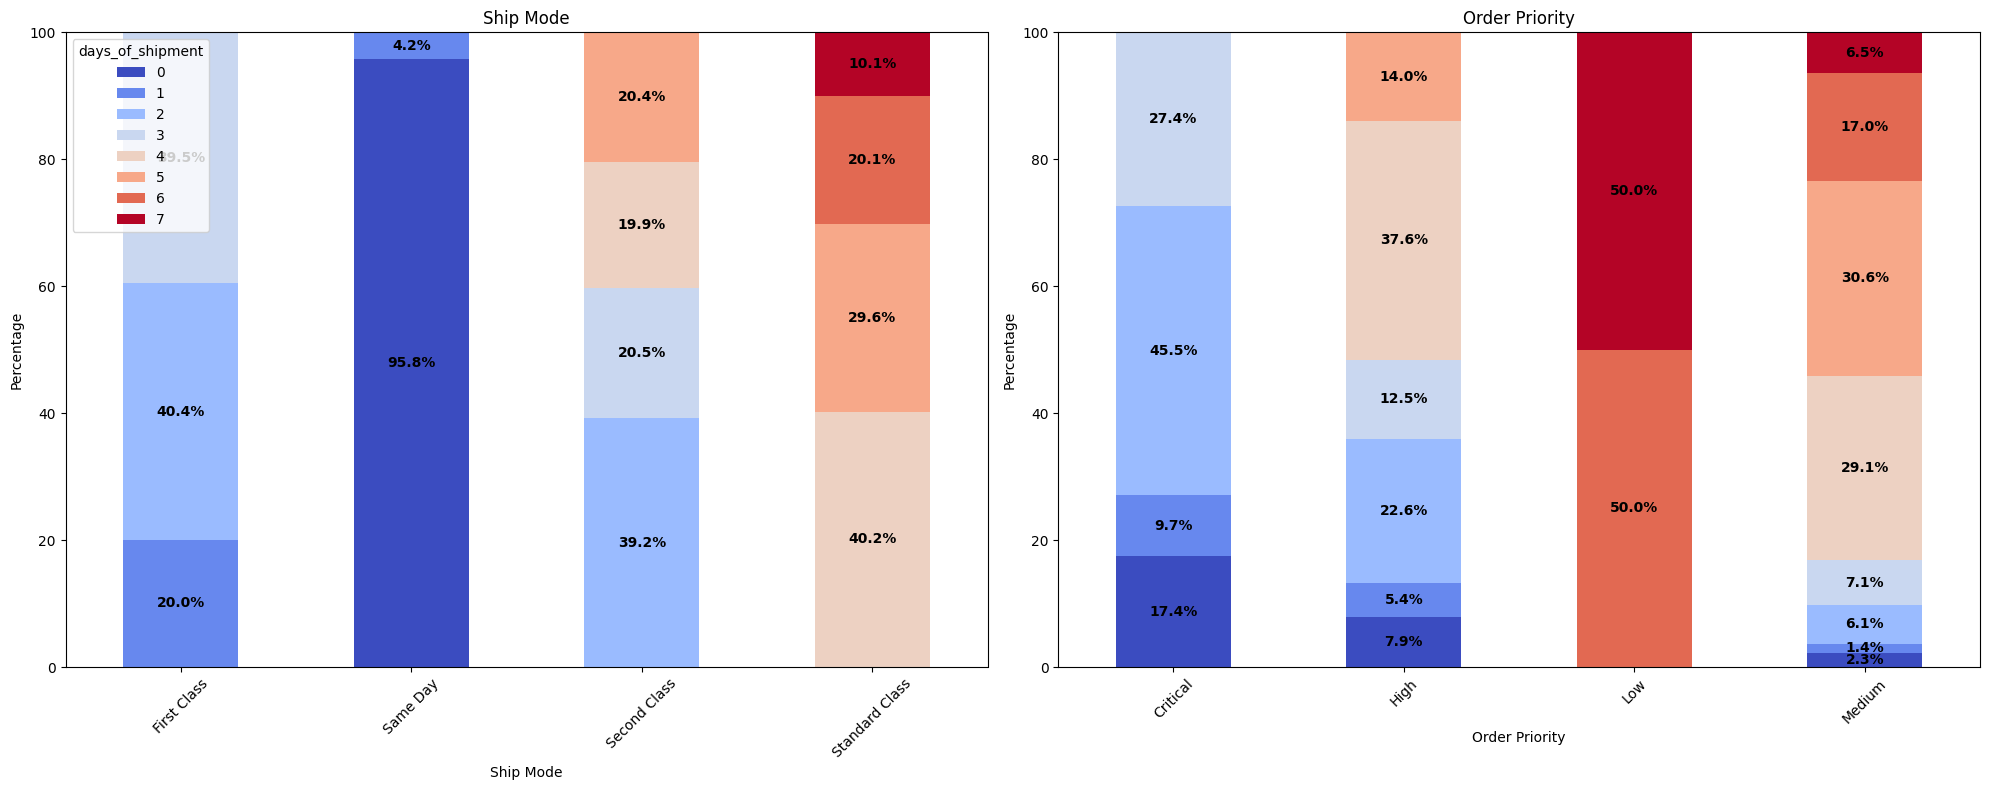

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Flatten the 2D axes array into a 1D array
axes = axes.flatten()

# Loop over columns to create individual subplots
for i, col in enumerate(['Ship Mode', 'Order Priority']):
    if i == 0:  # Show legend only for the first subplot
        per100_stack_shipment(axes[i], col, show_legend=True)
    else:
        per100_stack_shipment(axes[i], col, show_legend=False)
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', labelrotation=45)

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()

- This is also reasonable as we discussed earlier. The more premium the serivce, the more likely order will be devliverd first
- Same Day has 95,8% on time delivery which is very high, and closed to[ 96.5% of UPS](https://about.ups.com/vn/vi/our-stories/customer-first/ups-beats-competitors-in-on-time-holiday-deliveries-for-seven-ye.html) (best logistic company in the world)

Let 's explore the how number of order quantity and average days_of_shipment fluctuate together to determine whether company can adapt with increasing number of orders

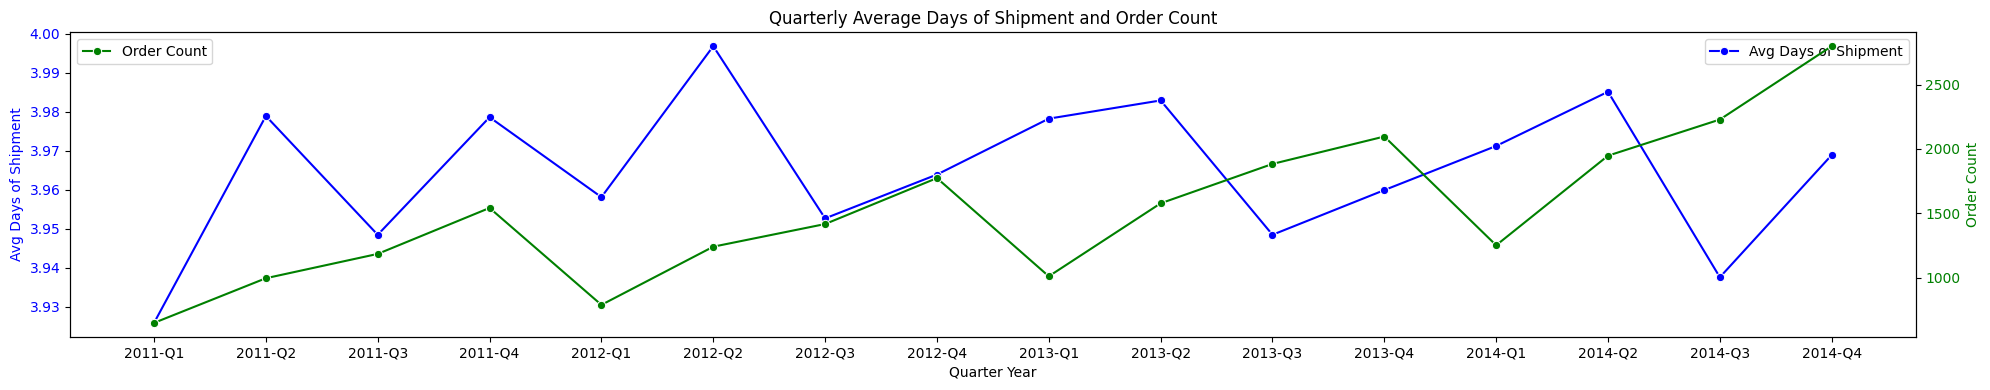

In [ ]:
quarterly_data = order.groupby('quarter_year').agg(
    avg_days_of_shipment=('days_of_shipment', 'mean'),
    order_count=('Order ID', 'count')
).reset_index()

# Create the figure and the first axis
fig, ax1 = plt.subplots(figsize=(20, 4))

# Plot avg_days_of_shipment on the first y-axis
sns.lineplot(data=quarterly_data, x='quarter_year', y='avg_days_of_shipment', marker='o', ax=ax1, color='b', label='Avg Days of Shipment')
ax1.set_ylabel('Avg Days of Shipment', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot order_count on the second y-axis
sns.lineplot(data=quarterly_data, x='quarter_year', y='order_count', marker='o', ax=ax2, color='g', label='Order Count')
ax2.set_ylabel('Order Count', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Title and labels
plt.title('Quarterly Average Days of Shipment and Order Count')
ax1.set_xlabel('Quarter Year')

# Display the chart
plt.tight_layout()
plt.show()

Despite the fact that the Order Quantity increase rapidly over time (from less than 500 at the beginning to nearly 3000 at the end which means 6 times larger), the average days_of_shipment is still stable (varied from 3.93 to 4)


--> Delivery system adapts well with rapid growth in number of quantity.

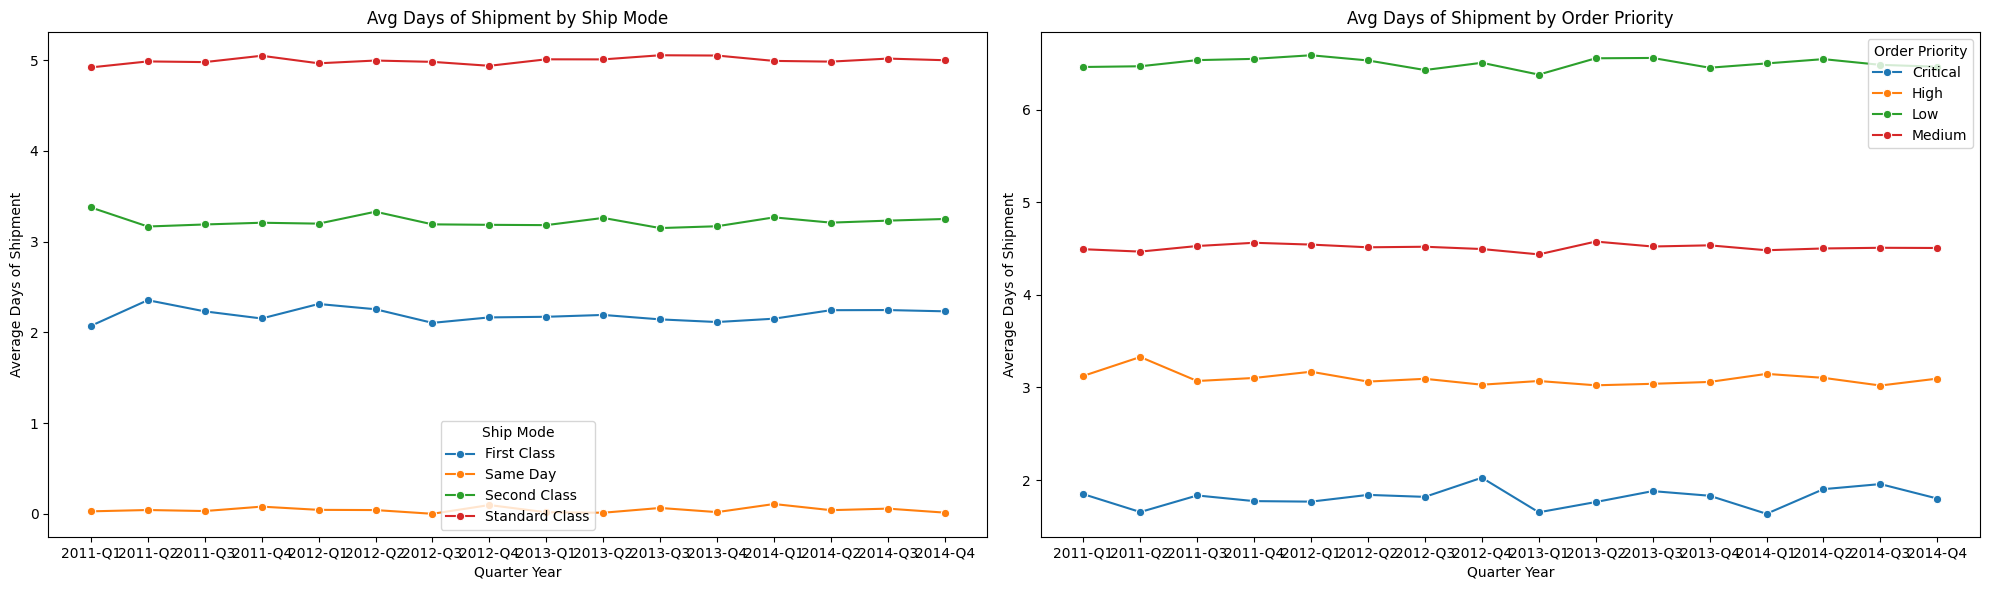

In [ ]:
# Group by quarter_year and calculate the mean of days_of_shipment for both Ship Mode and Order Priority
ship_mode_data = order.groupby(['quarter_year', 'Ship Mode'])['days_of_shipment'].mean().reset_index()
order_priority_data = order.groupby(['quarter_year', 'Order Priority'])['days_of_shipment'].mean().reset_index()

# Create the subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# First chart: average days_of_shipment with Ship Mode as legend
sns.lineplot(data=ship_mode_data, x='quarter_year', y='days_of_shipment', hue='Ship Mode', marker='o', ax=axes[0])
axes[0].set_title('Avg Days of Shipment by Ship Mode')
axes[0].set_xlabel('Quarter Year')
axes[0].set_ylabel('Average Days of Shipment')

# Second chart: average days_of_shipment with Order Priority as legend
sns.lineplot(data=order_priority_data, x='quarter_year', y='days_of_shipment', hue='Order Priority', marker='o', ax=axes[1])
axes[1].set_title('Avg Days of Shipment by Order Priority')
axes[1].set_xlabel('Quarter Year')
axes[1].set_ylabel('Average Days of Shipment')

# Display the charts
plt.tight_layout()
plt.show()

The average days_of_shipment is stabel over time for each Ship Mode, and Order Priority

Text(0, 0.5, 'Average Days of Shipment')

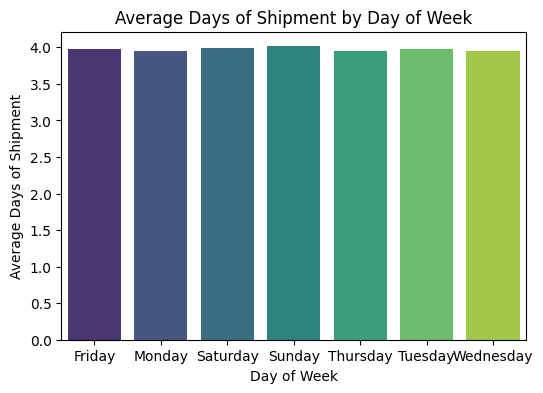

In [ ]:
day_of_week_avg = order.groupby('day_of_week')['days_of_shipment'].mean().reset_index()

# Plot the bar chart
plt.figure(figsize=(6, 4))
sns.barplot(data=day_of_week_avg, x='day_of_week', y='days_of_shipment', palette='viridis')

# Set labels and title
plt.title('Average Days of Shipment by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Days of Shipment')

This chart and previous chart show that customers will get a consistent delivery service regardless of the time that they order.


 --> Good and consistent customer experience

**Summary of Shipment**
- Orders usually deliver by basic service, as service advance, the number of orders get lower and lower
- Strong positive correlation between Order Priority and Ship Mode (premium Ship Mode tend to go hand in hand with premium Order Priority, and vice versa)
- days_of_shipment for Order Priority and Ship Mode is reasonable, as the premium service will have smaller days_of_shipment. These are also two factor that affect days_of_shipment the most
- Same Day (ship mode) get 95,8% on-time delivery which is nearly equal to [96.5% of UPS](https://about.ups.com/vn/vi/our-stories/customer-first/ups-beats-competitors-in-on-time-holiday-deliveries-for-seven-ye.html) (best logistic company in the world)
- Average delivery time is table while order quantity gets 6 times larger
- Customer get the same delivery service regardless when they order → consistent service, good reputation

--> Delivery service is very good (high on-time delivery percentage, adapt will to huge increase in demand, provide consistent service)


## 2.3 Product

### 2.3.1 Important Product

- This part will discuss important product to focus on. Especially, I try to find out Source of Revenue and Source of Growth.
- Give specific recommendation for each subcategory

Text(0, 0.5, 'Sales')

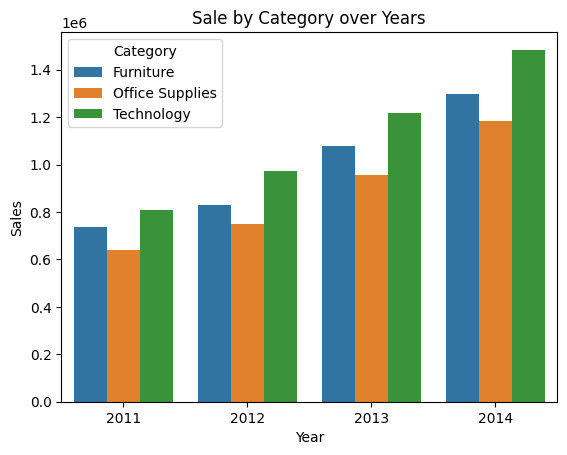

In [ ]:
# Get aggregated data for Category
category = df.groupby(['year', 'Category'])['Sales'].sum().reset_index()
category = category.sort_values(by=['Category', 'year'], ascending=True)
category['YoY_growth'] = round(category.groupby('Category')['Sales'].pct_change(), 4)
# Plot
sns.barplot(x=category['year'], y=category['Sales'], hue=category['Category'])
plt.title('Sale by Category over Years')
plt.xlabel('Year')
plt.ylabel('Sales')

Technology category is the category with the highest sale for all year. Let's have a closer look at this category

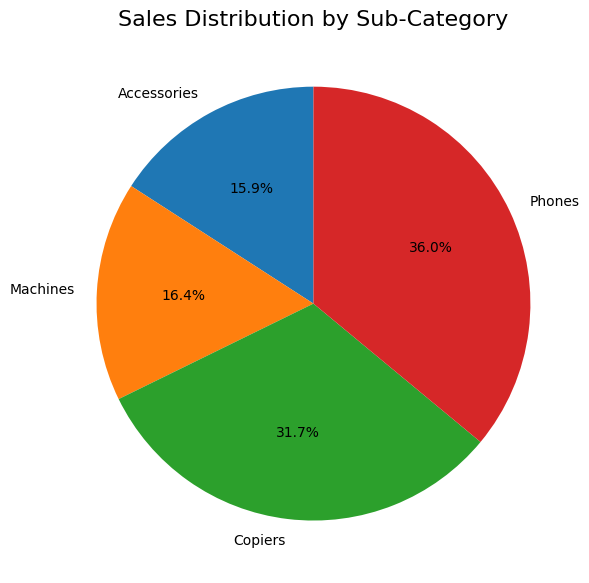

In [ ]:
# Get data for technology category
technology = df[df['Category']=='Technology'].groupby(by='Sub-Category')['Sales'].sum().reset_index().sort_values(by='Sales', ascending=True)
# Plot
plt.figure(figsize=(6, 6))
plt.pie(technology['Sales'], labels=technology['Sub-Category'], autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Sales Distribution by Sub-Category', fontsize=16)
plt.tight_layout()
plt.show()

Phones is the Sub-Category is the Technology that has the largest sales contribution. We will look deper into Product Name

In [ ]:
# Function for creating a chart from a group by operation
def groupby_chart(df, group, column, operation, ax, limit):
    '''
    Args:
    df            : data table
    group         : column that groupby on
    column        : column for operation
    ax            : to create subplot
    limit         : limit number of columns displayed

    Result:
    bar chart for groupby operation
    '''
    # Perform groupby and aggregation
    data = df.groupby(group)[column].agg(operation).round(2)
    data = data.sort_values(ascending=False).head(limit)
    # Convert Series to DataFrame to be compatible with seaborn
    data_df = data.reset_index()  # Convert to DataFrame with reset_index()
    if ax != None:
      # Create the barplot on the provided axis
      sns.barplot(data=data_df, x=group, y=column, ax=ax, color='#FF99AC')
      # Set chart title and formatting
      ax.set_title(f"{column} by {group}")
      ax.tick_params(axis='x', rotation=45, labelsize=10)
      ax.set_xlabel(group)
      ax.set_ylabel(operation.capitalize())
      for label in ax.get_xticklabels():
          label.set_ha('right')
    else:
      sns.barplot(data=data_df, x=group, y=column, color='#FF99AC')
      plt.title(f"{column} by {group}")
      plt.xticks(rotation=45, ha='right')
      plt.xlabel(group)
      plt.ylabel(operation)

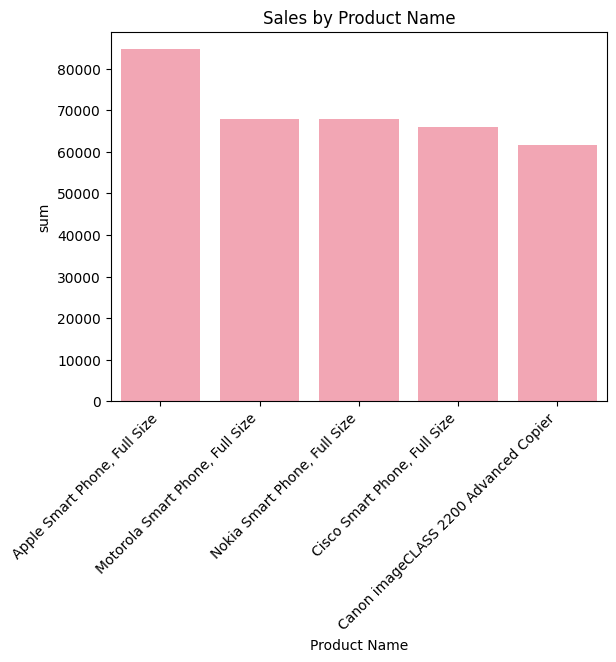

In [ ]:
groupby_chart(df, group='Product Name', column='Sales', operation='sum', ax=None, limit=5)


- Technology is the best performance out of all Category.
- Phones is the best performance Sub-Category in Technology.
- And 4/5 highest sale Product Name of this company are Phones.


--> Phones is current Source of Revenue

Now we have found the source of current revenue. Let 's find out Sourcce of Growth for future.

In [ ]:
# Aggregate by category
subcategory = df.groupby(['year', 'Sub-Category']).agg({
    'Sales': 'sum',
    'Profit': 'sum'
}).reset_index()
subcategory['profit_margin'] = round(subcategory['Profit']/subcategory['Sales'], 4)
subcategory = subcategory.sort_values(by=['Sub-Category', 'year'], ascending=True)
subcategory['YoY_growth'] = round(subcategory.groupby('Sub-Category')['Sales'].pct_change(), 4)
# Find out subcategory with the higest YoY growth over time
subcategory.groupby(by='Sub-Category')['YoY_growth'].mean().reset_index().sort_values(by='YoY_growth', ascending=False).head()

Sub-Category  YoY_growth
6      Copiers    0.337833
0  Accessories    0.297867
8    Fasteners    0.258500
1   Appliances    0.254833
9  Furnishings    0.253800

Copiers is the subcategory that has the highest YoY growth and significantly higher than the second place.

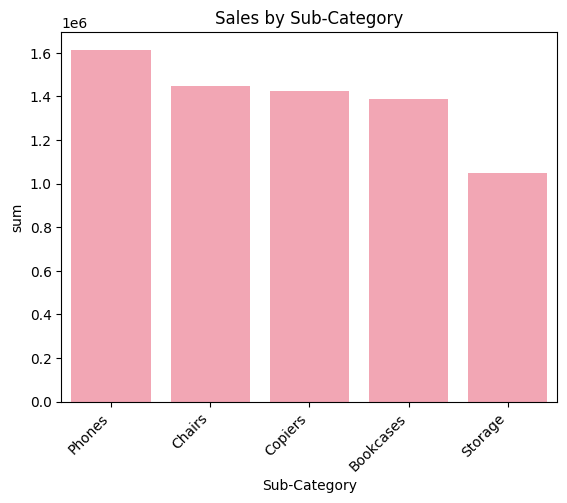

In [ ]:
# We will explore top 5 highest sale subcategory
groupby_chart(df, group='Sub-Category', column='Sales', operation='sum', ax=None, limit=5)


Copiers is subcategory with:

*   Highest YoY growth
*   Third highest sale revenue

--> Copiers is the Source of Growth revenue in the future (most potential)



Let 's look at Sale performance of Copiers in relation with top 5 sale subcateogry over time

Text(0, 0.5, 'Sales')

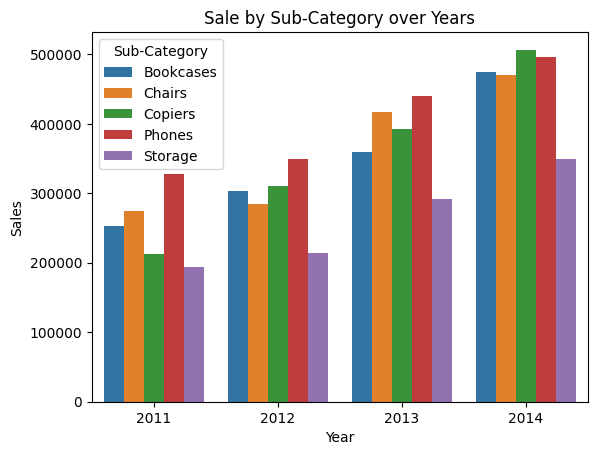

In [ ]:
sns.barplot(data=subcategory[subcategory['Sub-Category'].isin(['Phones', 'Chairs', 'Copiers', 'Storage', 'Bookcases'])], x='year', y='Sales', hue='Sub-Category')
plt.title('Sale by Sub-Category over Years')
plt.xlabel('Year')
plt.ylabel('Sales')

Copiers was at 3rd place in 2011, but has grown signficantly to the 1st place in 2014.

In [ ]:
subcategory_summary = subcategory.groupby('Sub-Category').agg(
    Sales=('Sales', 'sum'),
    Profit=('Profit', 'sum'),
    YoY_growth=('YoY_growth', 'mean')
).reset_index()
subcategory_summary['profit_margin'] = round(subcategory_summary['Profit']/subcategory_summary['Sales'], 4)
subcategory_summary.head()

Sub-Category         Sales       Profit  YoY_growth  profit_margin
0  Accessories  7.120267e+05  123461.8428    0.297867         0.1734
1   Appliances  9.371191e+05  136465.9249    0.254833         0.1456
2          Art  3.350994e+05   51141.2761    0.227633         0.1526
3      Binders  4.389938e+05   67932.0125    0.219467         0.1547
4    Bookcases  1.389882e+06  151403.0145    0.235233         0.1089

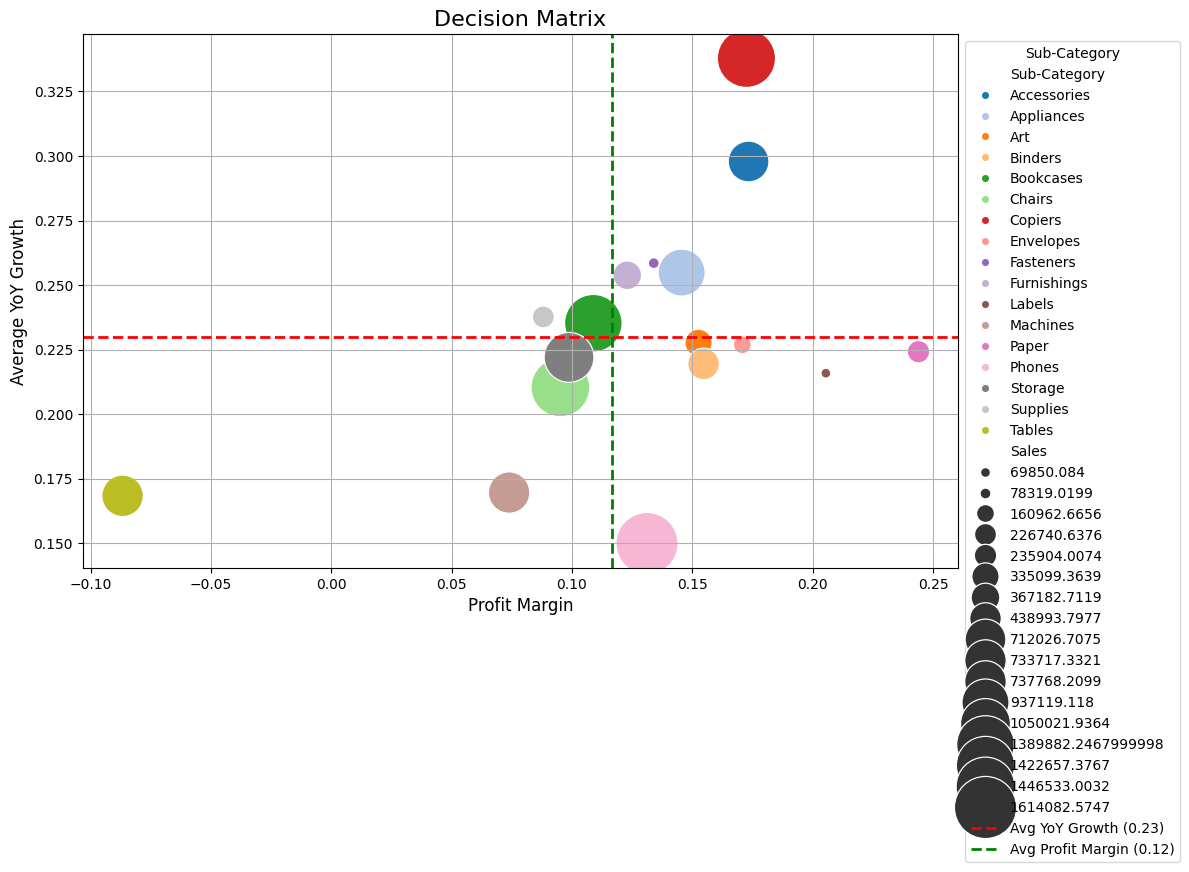

In [ ]:
average_YoY = subcategory_summary['YoY_growth'].mean()
# Set up the figure
plt.figure(figsize=(12, 8))

# Create the bubble chart
sns.scatterplot(
    x='profit_margin',
    y='YoY_growth',
    size='Sales',  # Bubble size based on Sales
    hue='Sub-Category',
    sizes=(50, 2000),  # Scale the bubble sizes (adjust this for better visualization)
    data=subcategory_summary,
    legend='full',  # Show the legend
    palette='tab20',  # Color palette
    alpha=1  # Transparency of the bubbles
)

# Title and labels
plt.title('Decision Matrix', fontsize=16)
plt.xlabel('Profit Margin', fontsize=12)
plt.ylabel('Average YoY Growth', fontsize=12)

# Adding horizontal and vertical lines for average values (compare performance of Sub-Category by average value)
plt.axhline(y=average_YoY, color='red', linestyle='--', linewidth=2, label=f'Avg YoY Growth ({average_YoY:.2f})')
plt.axvline(x=average_margin, color='green', linestyle='--', linewidth=2, label=f'Avg Profit Margin ({average_margin:.2f})')
# Show grid
plt.grid(True)

# Show the legend
plt.legend(title='Sub-Category', loc='upper left', bbox_to_anchor=(1, 1))

# Display the chart
plt.tight_layout()
plt.show()

Note: The size of the bubble is the total sale of Sub-Category

Explaination of Decision Matrix:
- Horizontal line and vertial line show average performance of sub-category and divide bubble chart in to 4 area --> Help us to make decision
- Upper right (high margin, high YoY): ideal area for subcategory, they are key subcategory in both the future and the current--> Company should monitor these core categories careful to maintain advanrages
- Lower right (high margin, low YoY): this area has potential to bring a lot of profit to company --> Should promote, target to specific cutomer segment
- Upper left: I will not talk about this because there is just one category and it is closed to intersection of two lines (no extreme)
- Lower left: (low margin, low YoY): these categories are saturated, growth is slowed down, while price competition decrease margin.

Insight from bubble chart:
- Copiers in the upper right is the most important subcategory in the present and the future. This subcategory has 3rd largest revenue, largest YoY, and large margin --> Core subcategory that need special care
- Accessories in the upper right is also at idea state
- Paper in the lower right has the largest margin, but YoY just below the average a little bit. This subcategory can bring a good amount of profit if is leveraged properly --> Target customer segment, promote subcategory
- Tables in lower left has lowest margin (~ -0.1) and near lowest YoY. This subcategory should be deleted due to low performance and bring lost to company
- Phones in lower right has the lowest YoY and margin is just above the average a little bit. This indicates that this subcategory will soon step to saturation stage
- All subcategories has at least 15% YoY and even better than [MWG growth revenue 14%](https://cdnv2.tgdd.vn/mwgvn/investorrelations/files/posts/2025/2/0/45/49/4549fa2b232edba1d0044bf7e0b3f3dd.pdf)

**Summary of Important Products**
- Phones subcategory, while is 1st current Source of Revenue will soon step into the Saturation stage → Maximize short term profit, reduce cost, maintain market share, can not phase out yet due to highest revenue
- Due to high margin and high YoY, Copiers and Accessories will be key subcategories in the future. And Copiers is also Source of Growth due to its highest growth and current 3rd largest revenue → Focus on scaling to acquire large market share, monitor carefully, considered as core subcategories
- Paper with its highest margin can bring good profit if it is leveraged properly → Focus on marketing, increase customer awareness, and target specific customer segment
- Tables, while generating good revenue, have the lowest margin and very low growth rate. → Create phase-out plan and deleted it as soon as possible  


### 2.3.2 Sales at Loss

In this part, we will discover why there are many products are sold at loss

Text(0, 0.5, 'Frequency')

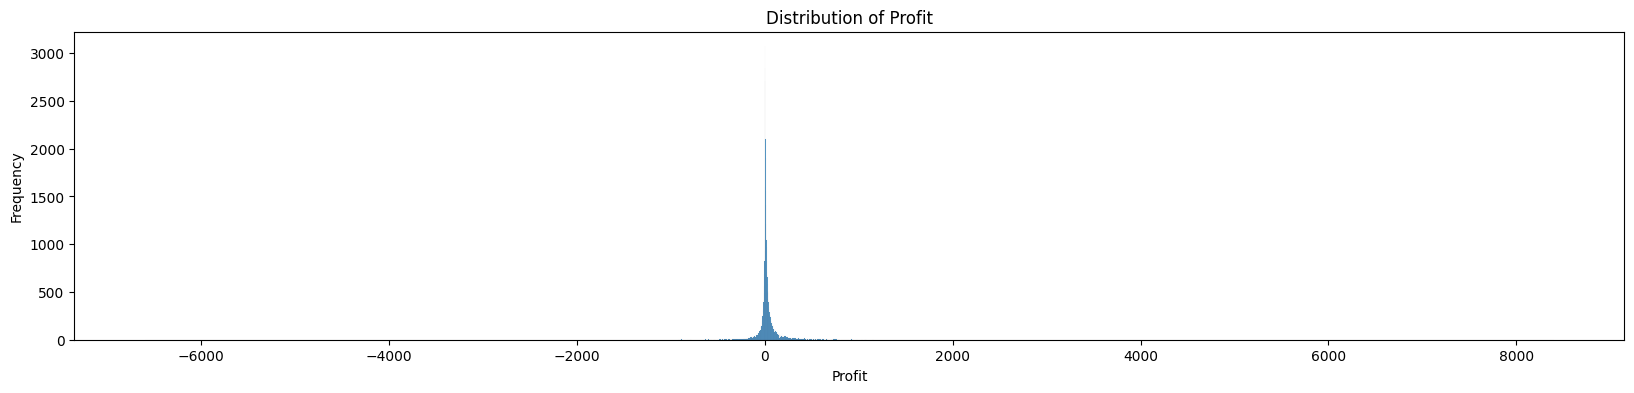

In [ ]:
plt.figure(figsize=(20, 4))
sns.histplot(df['Profit'])
plt.title('Distribution of Profit')
plt.xlabel('Profit')
plt.ylabel('Frequency')

There are many products that are sold at loss and even extreme loss

In [ ]:
print(f'The percentage of product sale at loss: {round(df[df["Profit"]<0].shape[0]/df.shape[0]*100, 2)}%')

The percentage of product sale at loss: 24.37%


Wow!!! 24% products are sold at loss, that is a lot for a company. We should figure out why this happens

In [ ]:
# Create a dataframe of products that have negative profit
sale_at_loss = df[df['Profit']<0]

Text(0.5, 0, 'Sub-Category')

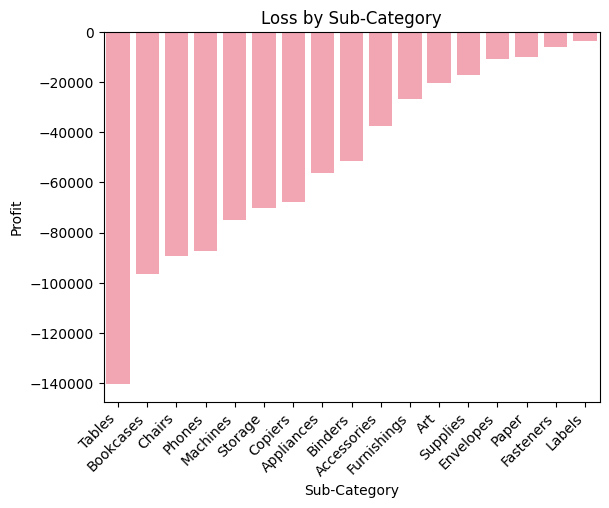

In [ ]:
sale_at_loss_subcategory = sale_at_loss.groupby('Sub-Category').agg(
    count=('Sub-Category', 'count'),
    profit=('Profit', 'sum')
    ).reset_index()
sns.barplot(x=sale_at_loss_subcategory.sort_values(by='profit', ascending=True)['Sub-Category'],
            y=sale_at_loss_subcategory.sort_values(by='profit', ascending=True)['profit'],
            color='#FF99AC')
plt.xticks(rotation=45, ha='right')
plt.title('Loss by Sub-Category')
plt.ylabel('Profit')
plt.xlabel('Sub-Category')


*   Phones is one the highest loss subcategory, this is due to firece price competition of a saturation market as I presented above
*   Loss by Tables subcategory is outstanding. I assume that this loss has a relationship with Discount. Let 's explore

In [ ]:
df.groupby('Sub-Category')['Discount'].mean().reset_index().sort_values(by='Discount', ascending=False).head()

Sub-Category  Discount
16       Tables  0.289964
3       Binders  0.182799
11     Machines  0.166630
5        Chairs  0.161321
4     Bookcases  0.153887


*   Tables also has outstanding Discount rate (x1.5 from second place)
*   This is suitable with strategy that I recommend above that we should get rid of this subcategory as soon as possible. Company now give large discount to get rid of Tables ASAP



In [ ]:
# Conclusion about sale_at_loss
print('In comparision with the initial dataframe, the sale_at_loss has: ')
print(f'- Lower Sales: {sale_at_loss["Sales"].median()} (sales at loss) < {df["Sales"].median()} (overall)')
print(f'- Higher Discount: {sale_at_loss["Discount"].median()} (sales at loss) > {df["Discount"].median()} (overall)')

In comparision with the initial dataframe, the sale_at_loss has: 
- Lower Sales: 64.44 (sales at loss) < 84.375 (overall)
- Higher Discount: 0.47 (sales at loss) > 0.0 (overall)


Text(0, 0.5, 'Profit Margin')

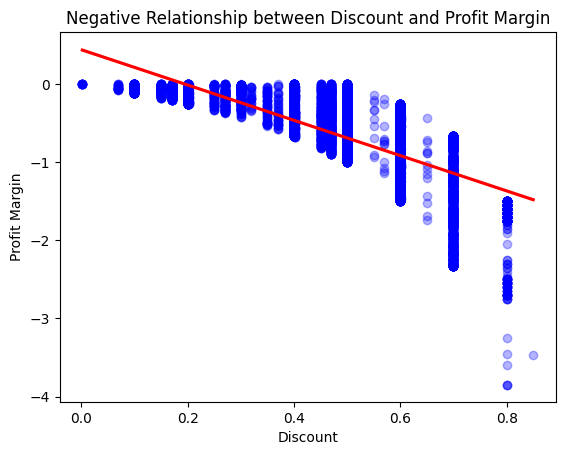

In [ ]:
sns.regplot(x=sale_at_loss["Discount"], y=sale_at_loss["profit_margin"], scatter_kws={'color': 'blue', 'alpha': 0.3}, line_kws={'color': 'red'})
plt.title('Negative Relationship between Discount and Profit Margin')
plt.xlabel('Discount')
plt.ylabel('Profit Margin')

This is a compelling evidence that loss is due to very high discount.

There are 3 possible reasons for this:
- Want to phase-out this categories (in case of Tables)
- Want to get rid of products that will be out of dated soon
- Want to maintain market share (in case of Phones)

**Summary of Sale at Loss**
- More than 24% products are sale at loss which is very large
- Loss is mainly due to high Discount. Company gives high discount because they want to get rid of products/subcategories ASAP, or price competition


## 2.4 Customer

### 2.4.1 Overview of Customer

Text(0, 0.5, 'Number of New Customers')

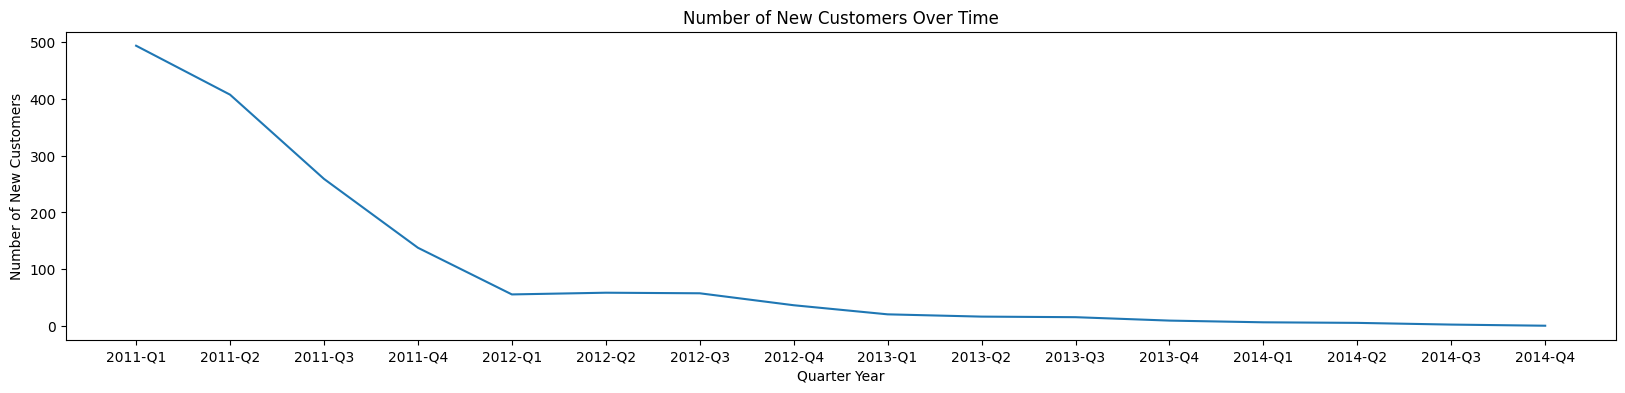

In [ ]:
# The code calculate new customer over time. We have new customer when they make first order
# Get the first order of each customer
add_customer = order.groupby('Customer ID')['Order Date'].min().reset_index()
# Aggregate by quarter
add_customer['quarter_year'] = add_customer['Order Date'].dt.year.astype(str) + '-Q' + add_customer['Order Date'].dt.quarter.astype(str)
add_customer_quarterly = add_customer.groupby('quarter_year')['Customer ID'].count().reset_index()
# Plot
plt.figure(figsize=(20, 4))
sns.lineplot(data=add_customer_quarterly, x='quarter_year', y='Customer ID')
plt.title('Number of New Customers Over Time')
plt.xlabel('Quarter Year')
plt.ylabel('Number of New Customers')


Number of new customers decrease significantly over time. That is a red  alert situation. Despite of this decrease, the sale and order quantity grow annually at a high rate.

--> Let's figure out why by looking at
1. percentage of repeat cusotmer,
2. number of orders per customer
3. number of orders over time

In [ ]:
# Calculate the percentage of repeat customer
order_per_customer = order.groupby('Customer ID')['Order ID'].count().reset_index()
order_per_customer['repeat_customer'] = order_per_customer['Order ID'].apply(lambda x: 1 if x > 1 else 0)
order_per_customer['repeat_customer'].value_counts(normalize=True)

repeat_customer
1    0.993703
0    0.006297
Name: proportion, dtype: float64

Wow !!! All customers of this company are repeat customer.

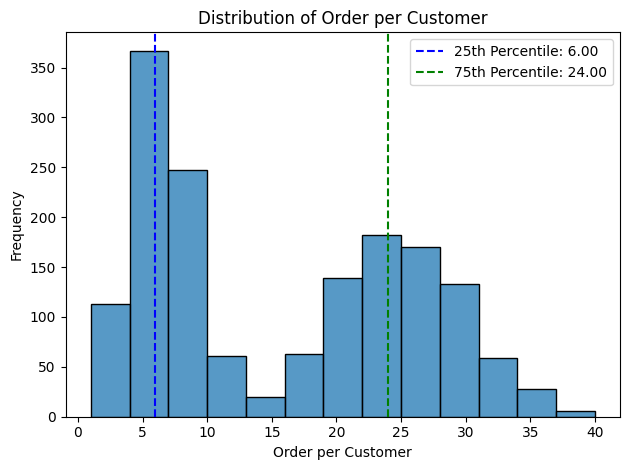

In [ ]:
# Plot the distribution of orders per customer
sns.histplot(order_per_customer['Order ID'])
plt.title('Distribution of Order per Customer')
plt.xlabel('Order per Customer')
plt.ylabel('Frequency')

# Get the 25th (Q1) and 75th (Q3) percentiles
q1_order_id = order_per_customer['Order ID'].quantile(0.25)
q3_order_id = order_per_customer['Order ID'].quantile(0.75)

# Add vertical lines for the 25th and 75th percentiles
plt.axvline(x=q1_order_id, color='blue', linestyle='--', label=f'25th Percentile: {q1_order_id:.2f}')
plt.axvline(x=q3_order_id, color='green', linestyle='--', label=f'75th Percentile: {q3_order_id:.2f}')
plt.legend(loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()

A typical customer orders a lot of times

Text(0.5, 0, 'Quarter Year')

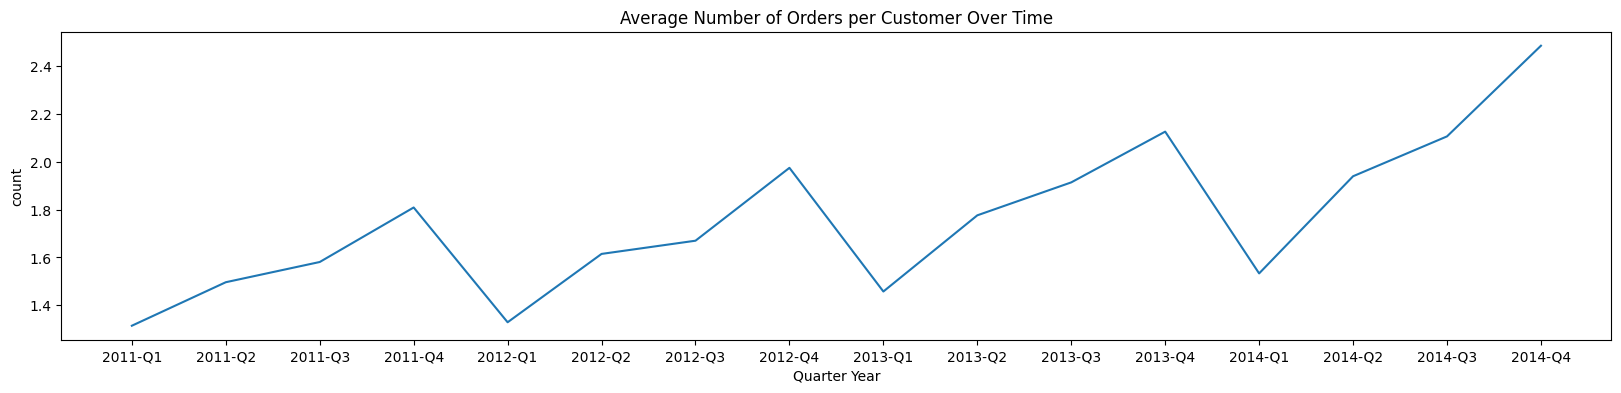

In [ ]:
number_of_order_quarterly =  order.groupby(['quarter_year', 'Customer ID']).agg(
    count=('Order ID', 'count')
).reset_index().groupby('quarter_year')['count'].mean().reset_index()
plt.figure(figsize=(20, 4))
sns.lineplot(data=number_of_order_quarterly, x='quarter_year', y='count')
plt.title('Average Number of Orders per Customer Over Time')
plt.xlabel('Quarter Year')

Number of order has a upward trend.

**Summary of Overview of Customer**

Although new customer decrease rapidly. Sale and Order Quantity still grow annually due to:
- Nearly 100% repeat customer
- High order per customer
- Increase order per customer over time


--> This indicates that company has successfully established a loyal customer base and company relies on loyal customer heavily.

### 2.4.2 Customer segmentation with KMeans

In [ ]:
# Create a summary table about customers
customer = df.groupby(['Customer ID', 'Segment']).agg({
    'Order ID': 'nunique',
    'Quantity': 'sum',
    'Sales': 'sum',
    'Profit': 'sum'
}).round(2)
# Sort by Sales in descending order
customer = customer.sort_values(by='Sales', ascending=False).reset_index()
# Rename
customer = customer.rename(columns={'Order ID':'total_orders', 'Quantity':'total_quantity', 'Sales':'total_sales', 'Profit':'total_profit'})
# Feature engineering
customer['profit_margin'] = (customer['total_profit'] / customer['total_sales']).round(2)
customer['aov'] = (customer['total_sales'] / customer['total_orders']).round(2)
customer['average_item_per_order'] = (customer['total_quantity'] / customer['total_orders']).round(2)

# Merge customer table with data table of average time between orders for each customer
avg_reorder_time = reorder_no_first.groupby('Customer ID')['Time from Previous Order (days)'].mean().reset_index()
customer = pd.merge(customer, avg_reorder_time, on='Customer ID')

customer.head()

Customer ID      Segment  total_orders  total_quantity  total_sales  \
0    TA-21385  Home Office            23             211     33933.09   
1    TC-20980    Corporate            26             195     33501.36   
2    GT-14710     Consumer            28             270     31403.68   
3    BW-11110    Corporate            34             308     29860.86   
4    HL-15040     Consumer            19             196     29512.85   

   total_profit  profit_margin      aov  average_item_per_order  \
0       5943.47           0.18  1475.35                    9.17   
1       8635.82           0.26  1288.51                    7.50   
2       4698.09           0.15  1121.56                    9.64   
3       3302.07           0.11   878.26                    9.06   
4       7654.53           0.26  1553.31                   10.32   

   Time from Previous Order (days)  
0                        57.454545  
1                        52.320000  
2                        51.333333  
3                        39.181818  
4                        78.333333

Text(0.5, 1.0, 'Correlation Matrix')

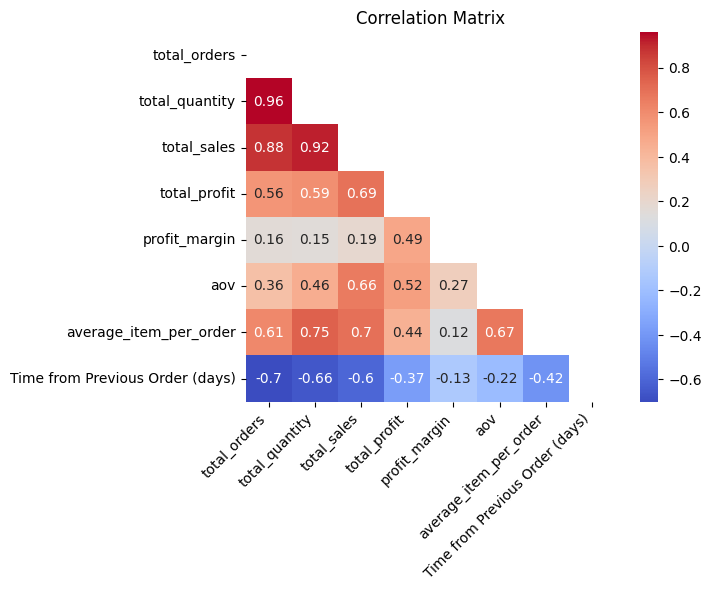

In [ ]:
# Correlation matrix
correlation_matrix = customer.corr(numeric_only=True)
sns.heatmap(correlation_matrix.round(2), annot=True, cmap='coolwarm',
            mask=np.triu(correlation_matrix), square=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Matrix')

There are many pairs of variables with strong correlation. I will use PCA to reduce noise.

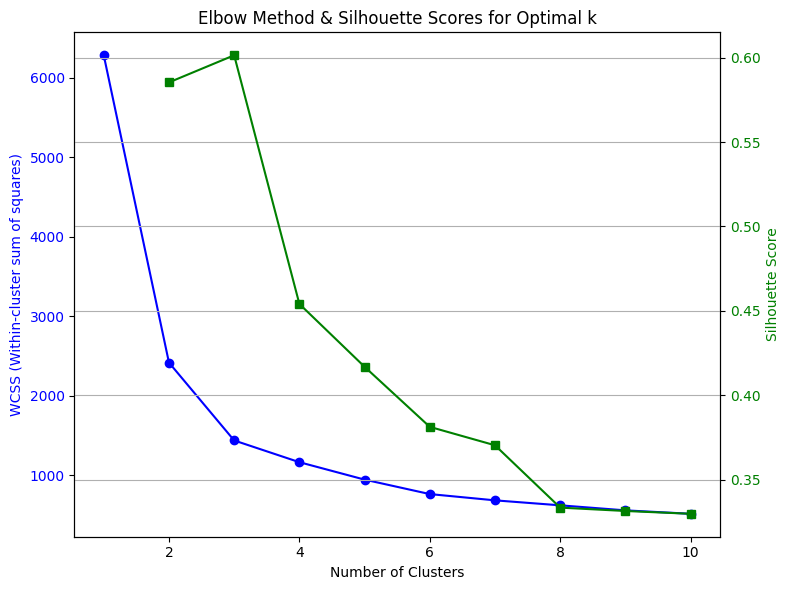

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Step 1: Standardize the features
features = customer[['profit_margin', 'total_orders', 'total_sales', 'average_item_per_order', 'Time from Previous Order (days)']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Step 2: Apply PCA to reduce the data to 2 dimensions
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Step 3: Use the Elbow Method to determine the optimal number of clusters (WCSS)
wcss = []  # Within-cluster sum of squares (WCSS)
for i in range(1, 11):  # Trying from 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(features_pca)
    wcss.append(kmeans.inertia_)

# Step 4: Calculate the Silhouette Score for different numbers of clusters
silhouette_scores = []
for i in range(2, 11):  # Silhouette score requires at least 2 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(features_pca)
    score = silhouette_score(features_pca, kmeans.labels_)
    silhouette_scores.append(score)

# Step 5: Plot both WCSS (Elbow Method) and Silhouette Scores with two y-axes
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot the Elbow Method graph (WCSS)
ax1.plot(range(1, 11), wcss, color='b', marker='o', label='WCSS')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('WCSS (Within-cluster sum of squares)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for Silhouette Scores
ax2 = ax1.twinx()
ax2.plot(range(2, 11), silhouette_scores, color='g', marker='s', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Add titles and grid
plt.title('Elbow Method & Silhouette Scores for Optimal k')
fig.tight_layout()  # Adjust layout to prevent overlap
plt.grid(True)
plt.show()

The best number of cluster is 3

In [ ]:
# Apply Kmeans wiht 3 cluster
# Step 1: Perform K-Means clustering with k=3
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans.fit(features_pca)

# Step 2: Assign the cluster labels to the original customer data
customer['Cluster'] = kmeans.labels_

In [ ]:
# Let 's have a look at customer with their new segment
customer[['Customer ID', 'Cluster']].head()

Customer ID  Cluster
0    TA-21385        0
1    TC-20980        0
2    GT-14710        0
3    BW-11110        0
4    HL-15040        0

In [ ]:
customer['Cluster'].value_counts(normalize=True)

Cluster
0    0.499366
1    0.406844
2    0.093790
Name: proportion, dtype: float64

Cluster 0 and 1 account for majority of customers

Let's have a look at those Cluster in scatter chart

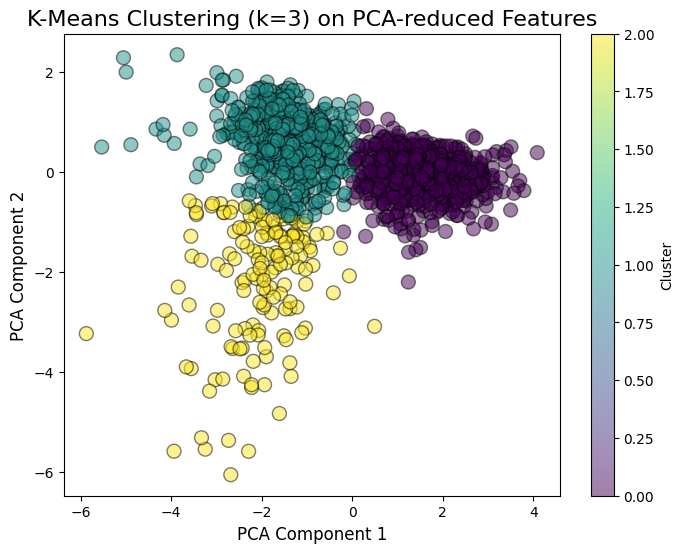

In [ ]:
plt.figure(figsize=(8, 6))

# Plot each cluster with different colors
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=customer['Cluster'], cmap='viridis', s=100, edgecolor='k', alpha=0.5)
plt.title('K-Means Clustering (k=3) on PCA-reduced Features', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)

# Add colorbar to show cluster labels
plt.colorbar(label='Cluster')
plt.show()

Clusters are well separated. --> Our clustering algorithm works well

Let's discover the characteristic of each segment

In [ ]:
xxx = customer.groupby('Cluster').agg(
    total_orders=('total_orders', 'sum'),
    total_sales=('total_sales', 'sum'),
    total_profit=('total_profit', 'sum'),
    total_quantity=('total_quantity', 'sum'),
    avg_reorder_time=('Time from Previous Order (days)', 'median')
).reset_index()
xxx['profit_margin'] = (xxx['total_profit'] / xxx['total_sales']).round(2)
xxx['aov'] = (xxx['total_sales'] / xxx['total_orders']).round(2)
xxx['average_item_per_order'] = (xxx['total_quantity'] / xxx['total_orders']).round(2)
xxx[['Cluster','avg_reorder_time', 'profit_margin', 'aov', 'average_item_per_order']]

Cluster  avg_reorder_time  profit_margin     aov  average_item_per_order
0        0         55.543478           0.12  531.09                    7.53
1        1        186.166667           0.17  349.61                    4.55
2        2        209.452381          -0.42  236.63                    4.64

Characterristic of each Cluster
- Cluster 0: order most frequently (x4 compare with Cluster 1, 2), AOV highest (x1.5-2 with other cluster), most item (x2) --> High Value Segment
- Cluster 1: average_item_per_order and avg_reorder_time are similar to Cluster 0, but AOV is x1.5 times larger than Cluster 0. The margin for this segment is largest (x1.5 times when compared with average margin 0.1166)--> High Margin Segment
- Cluster 2: has extremely negative profit margin. I assume that this segment buys products with very high discount. If my assumption is true we called Cluster 2 is Low Value Segment

In [ ]:
# Add Cluster label to the original dataframe
df = df.merge(customer[['Customer ID', 'Cluster']], on='Customer ID', how='inner')


In [ ]:
# Calculate a typlica discount of each segment
df.groupby('Cluster')['Discount'].median()

Cluster
0    0.00
1    0.00
2    0.45
Name: Discount, dtype: float64

This comfirms my assumption. When High Value and High Margin segment do not typically buy with discount, Cluster 2 buys with nearyly 50% discount --> Low Value Segment

In [ ]:
# Add Cluster label to Order table
order = order.merge(customer[['Customer ID', 'Cluster']], on='Customer ID', how='inner')

Text(0.5, 0, 'Quarter Year')

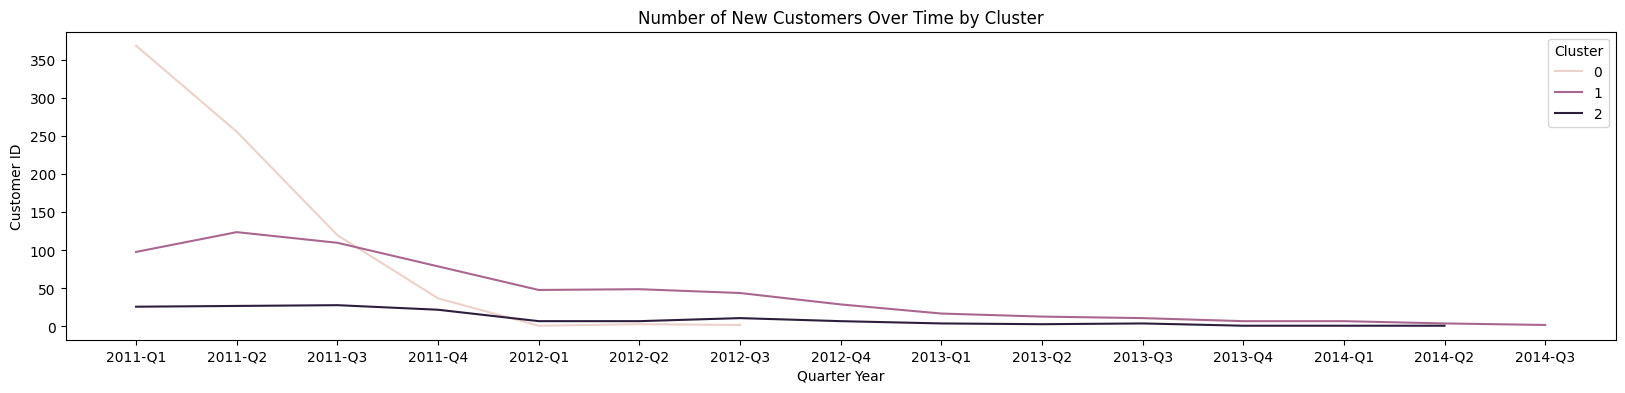

In [ ]:
# This code calculates new customer over time for each Segment of KMean.
add_customer = add_customer.merge(customer[['Customer ID', 'Cluster']], on='Customer ID', how='inner')
add_customer_quarterly_by_cluster = add_customer.groupby(['Cluster', 'quarter_year'])['Customer ID'].count().reset_index()
plt.figure(figsize=(20, 4))
sns.lineplot(data=add_customer_quarterly_by_cluster, x='quarter_year', y='Customer ID', hue='Cluster')
plt.title('Number of New Customers Over Time by Cluster')
plt.xlabel('Quarter Year')

- Cluster 0 (High Value segment) declined sharply from Q1/2011 to Q4/2011, after Q3/2012, the company does not have any new customer in the Segment. This is an seriour problem because this segment brings the highest revenue, profit, AOV.

- The other two Cluster also have a decline trends.

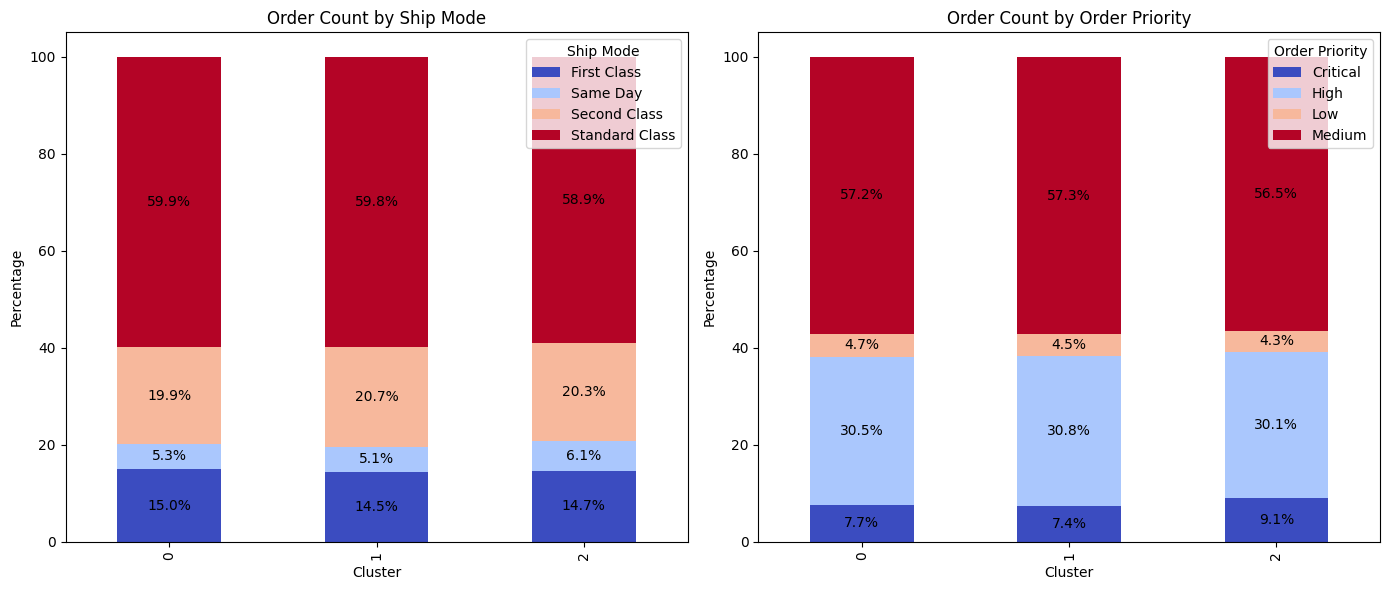

In [ ]:
ship_mode_data = order.groupby(['Cluster', 'Ship Mode']).size().unstack(fill_value=0)
order_priority_data = order.groupby(['Cluster', 'Order Priority']).size().unstack(fill_value=0)

# Normalize the data to get 100% stacked bar charts
ship_mode_data_percent = ship_mode_data.div(ship_mode_data.sum(axis=1), axis=0) * 100
order_priority_data_percent = order_priority_data.div(order_priority_data.sum(axis=1), axis=0) * 100

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First plot - Ship Mode
ship_mode_plot = ship_mode_data_percent.plot(kind='bar', stacked=True, ax=axes[0],
                                              title='Order Count by Ship Mode', colormap='coolwarm')
axes[0].set_ylabel('Percentage')
axes[0].set_xlabel('Cluster')

# Annotate the bars for Ship Mode chart
for p in ship_mode_plot.patches:
    height = p.get_height()
    if height > 0:  # only annotate if height is non-zero
        axes[0].annotate(f'{height:.1f}%',
                         (p.get_x() + p.get_width() / 2., p.get_y() + height / 2.),
                         xytext=(0, 0), textcoords='offset points', ha='center', va='center')

# Second plot - Order Priority
order_priority_plot = order_priority_data_percent.plot(kind='bar', stacked=True, ax=axes[1],
                                                       title='Order Count by Order Priority', colormap='coolwarm')
axes[1].set_ylabel('Percentage')
axes[1].set_xlabel('Cluster')

# Annotate the bars for Order Priority chart
for p in order_priority_plot.patches:
    height = p.get_height()
    if height > 0:  # only annotate if height is non-zero
        axes[1].annotate(f'{height:.1f}%',
                         (p.get_x() + p.get_width() / 2., p.get_y() + height / 2.),
                         xytext=(0, 0), textcoords='offset points', ha='center', va='center')

plt.tight_layout()
plt.show()

The above chart indicates that there is no correlation between Cluster and Ship Mode - Order Priority.

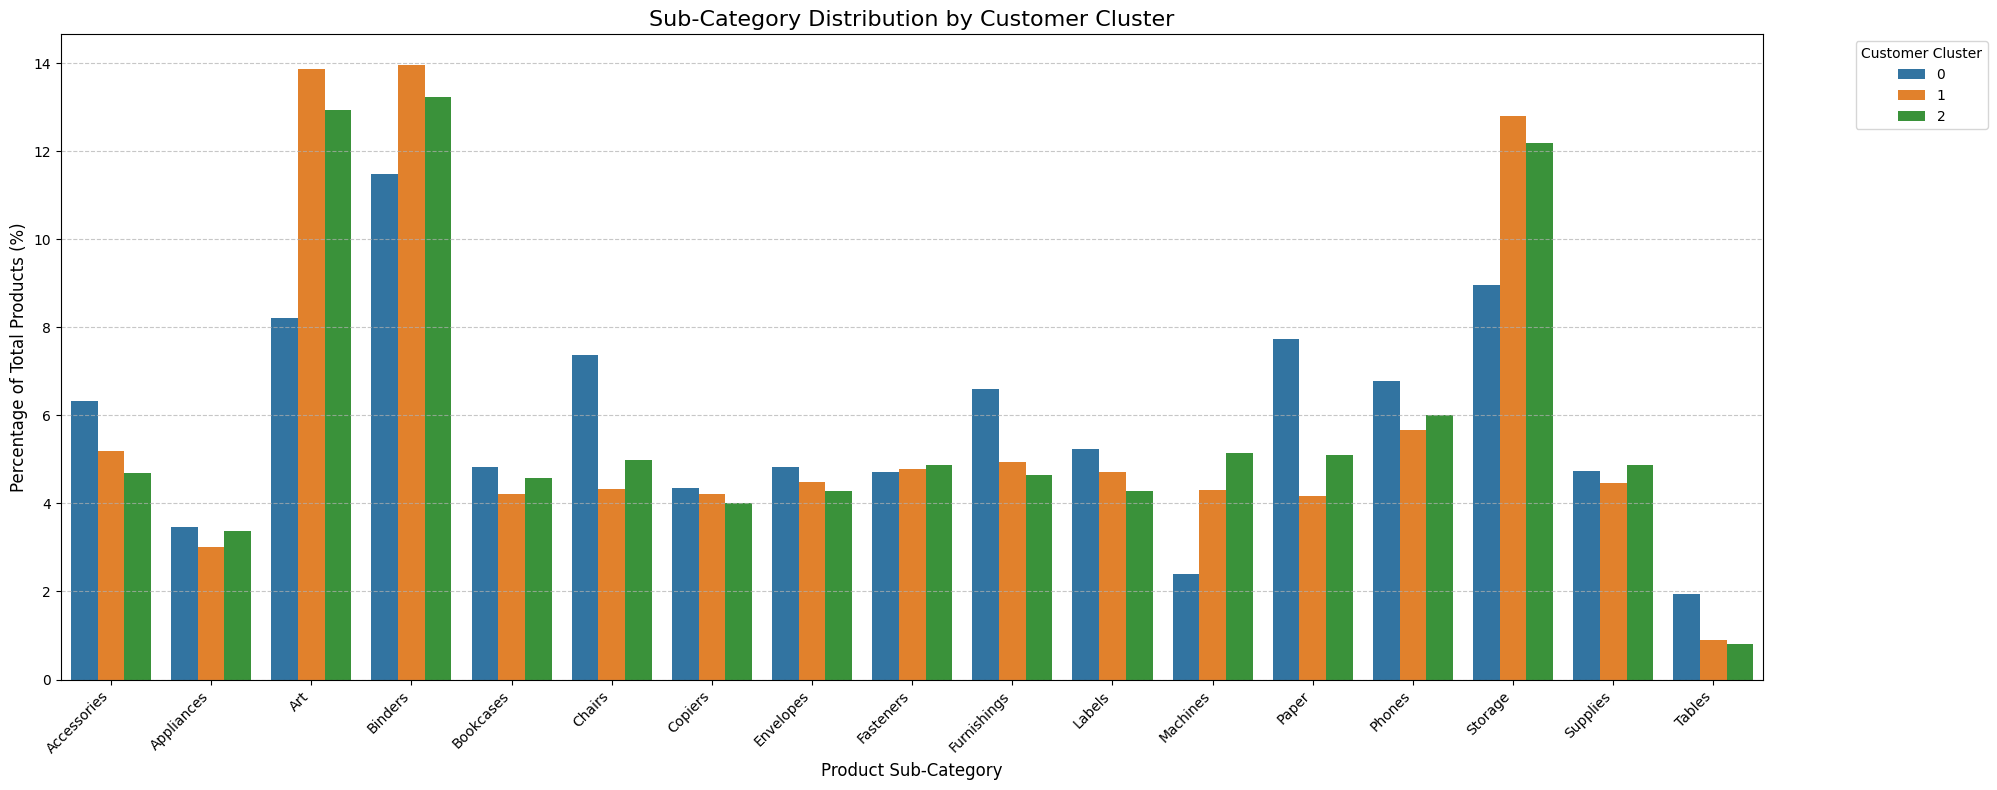

In [ ]:
cluster_subcategory_percent = (
    df.groupby(['Cluster', 'Sub-Category'])['Sub-Category']
    .count()
    .groupby(level=0)
    .transform(lambda x: 100 * x / x.sum())
    .reset_index(name='Percentage')
)

# Create the plot
plt.figure(figsize=(20, 8))
sns.barplot(
    x='Sub-Category',
    y='Percentage',
    hue='Cluster',
    data=cluster_subcategory_percent,
    palette='tab10',
    ci=None
)

# Customize the plot
plt.title('Sub-Category Distribution by Customer Cluster', fontsize=16)
plt.xlabel('Product Sub-Category', fontsize=12)
plt.ylabel('Percentage of Total Products (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Customer Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


- Cluster 0 buys more Paper and Chair than other Clusters
- Cluster 1 and 2 have similar pattern of preference, and buy more Art, Binder, and Storage.
--> Customize promotion for each customer segment.

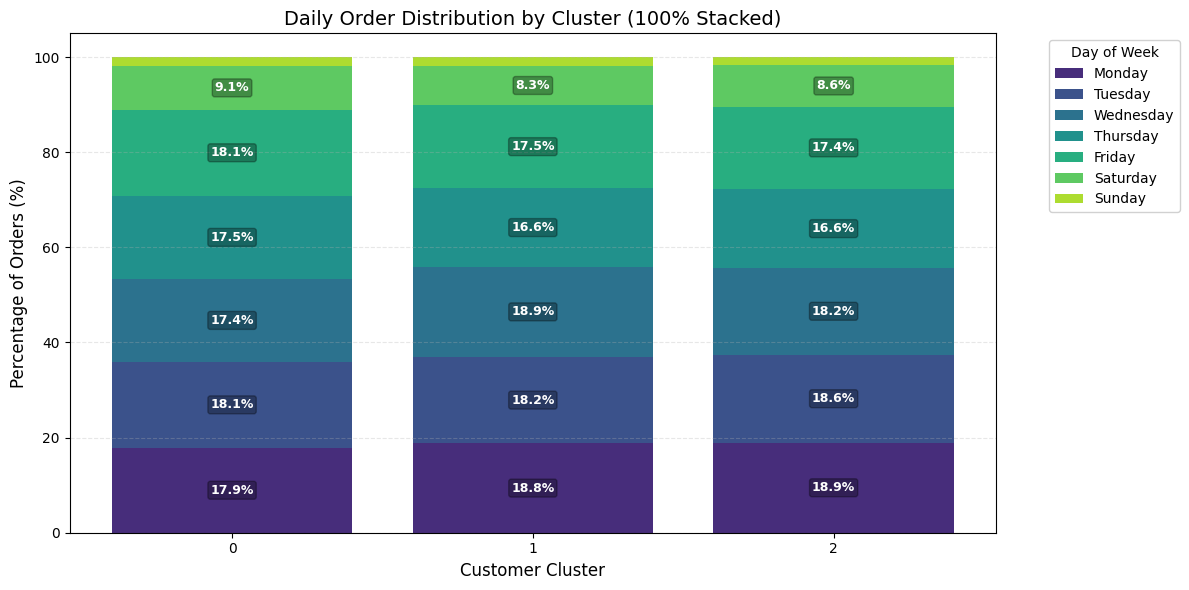

In [ ]:
# Prepare data - calculate percentages
cluster_day_percent = (
    order.groupby(['Cluster', 'day_of_week'])['Order ID']
    .count()
    .groupby(level=0)
    .transform(lambda x: 100 * x / x.sum())
    .reset_index(name='Percentage')
)

# Pivot the data for plotting
pivot_df = cluster_day_percent.pivot(index='Cluster', columns='day_of_week', values='Percentage')
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_df = pivot_df.reindex(columns=days_order)
colors = sns.color_palette('viridis', n_colors=len(days_order))

# Create the stacked bar chart with annotations
plt.figure(figsize=(12, 6))

# Initialize bottom for stacking
bottom = [0] * len(pivot_df.index)

# Plot each day as a separate layer
for i, day in enumerate(days_order):
    plt.bar(
        pivot_df.index,
        pivot_df[day],
        bottom=bottom,
        label=day,
        color=colors[i]
    )
    bottom = [b + h for b, h in zip(bottom, pivot_df[day])]

# Add percentage annotations
cumulative = pivot_df.cumsum(axis=1)  # Cumulative percentages for positioning
for cluster in pivot_df.index:
    for i, day in enumerate(days_order):
        percentage = pivot_df.loc[cluster, day]

        # Only annotate segments larger than 5% for readability
        if percentage > 5:
            # Calculate vertical position for annotation
            if i == 0:
                y_pos = percentage / 2
            else:
                prev_day = days_order[i-1]
                y_pos = cumulative.loc[cluster, prev_day] + (percentage / 2)

            plt.text(
                x=cluster,
                y=y_pos,
                s=f'{percentage:.1f}%',
                ha='center',
                va='center',
                color='white',
                fontsize=9,
                fontweight='bold',
                bbox=dict(facecolor='black', alpha=0.3, boxstyle='round,pad=0.2')
            )

# Customize the plot
plt.title('Daily Order Distribution by Cluster (100% Stacked)', fontsize=14)
plt.xlabel('Customer Cluster', fontsize=12)
plt.ylabel('Percentage of Orders (%)', fontsize=12)
plt.xticks(pivot_df.index)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Add legend with improved visibility
plt.legend(
    title='Day of Week',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    frameon=True,
    framealpha=0.9
)

plt.tight_layout()
plt.show()

Two segments do not have distinct behavior about day_of_week that they tend to buy.

**Summary of Customer Segmentation with KMean**

We have discovered three customer segment, and analyze each segment's characteristic. Three segment are:
- High Value: help to increase revenue, and boost growth for company. They are mainly care about the intrinsic value of products and willing to pay large amount of it
- High Margin: help to increase profit_margin of company
- Low Value: help company to get rid of out of dated products. If we want to get rid of products that will be out of dated soon, we can offer high discount for this segment, and they will help us to buy it. Price is the main concern of this group.

Segment behavior:
- High Value segment buys more Paper and Chair than other segments. Low Value and High Margin share a similar preference across products, and buy much more Art, Binder, and Storage.
- day_of_week, Order Priority, Ship Mode are the same for all 3 clusters.

The number of new customers in High Value declined sharply. After Q3/2012, there is no more new customers in this segment. This is very serious problem because this segment brings the most revenue and profit.

--> This will help company in developing different strategies for different segment

# 3. Sales Prediction

In this part, I will develop predictive model for sale prediction. I will use XGBoost, LSTM and Prophet
- XGBoost: (Extreme Gradient Boosting) is a powerful machine learning algorithm  uses decision trees as base learners and applies gradient boosting to improve accuracy by iteratively correcting errors made by previous trees. It’s known for its speed, performance, and ability to handle large datasets.

- LSTM (Long Short-Term Memory): type of recurrent neural network (RNN) designed to model sequential data. It has memory cells that can store information for long periods, making it effective for tasks such as time-series forecasting. LSTM addresses the vanishing gradient problem, allowing it to capture long-range dependencies in data.

- Prophet: Prophet is a forecasting tool developed by Facebook for predicting time-series data. It’s particularly useful for data with strong seasonal patterns and missing values. Prophet decomposes the time series into trends, seasonality, and holidays to make accurate predictions, and it's easy to use with minimal data preparation.

In [ ]:
df.head()

Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0     AG-2011-2040 2011-01-01 2011-01-06  Standard Class    TB-11280   
1    IN-2011-47883 2011-01-01 2011-01-08  Standard Class    JH-15985   
2     HU-2011-1220 2011-01-01 2011-01-05    Second Class      AT-735   
3  IT-2011-3647632 2011-01-01 2011-01-05    Second Class    EM-14140   
4    IN-2011-47883 2011-01-01 2011-01-08  Standard Class    JH-15985   

       Segment         City            State    Country  Market   Region  \
0     Consumer  Constantine      Constantine    Algeria  Africa   Africa   
1     Consumer  Wagga Wagga  New South Wales  Australia    APAC  Oceania   
2     Consumer     Budapest         Budapest    Hungary    EMEA     EMEA   
3  Home Office    Stockholm        Stockholm     Sweden      EU    North   
4     Consumer  Wagga Wagga  New South Wales  Australia    APAC  Oceania   

         Product ID         Category Sub-Category  \
0  OFF-TEN-10000025  Office Supplies      Storage   
1   OFF-SU-10000618  Office Supplies     Supplies   
2  OFF-TEN-10001585  Office Supplies      Storage   
3   OFF-PA-10001492  Office Supplies        Paper   
4   FUR-FU-10003447        Furniture  Furnishings   

                  Product Name    Sales  Quantity  Discount   Profit  \
0          Tenex Lockers, Blue  408.300         2       0.0  106.140   
1     Acme Trimmer, High Speed  120.366         3       0.1   36.036   
2      Tenex Box, Single Width   66.120         4       0.0   29.640   
3  Enermax Note Cards, Premium   44.865         3       0.5  -26.055   
4   Eldon Light Bulb, Duo Pack  113.670         5       0.1   37.770   

   Shipping Cost Order Priority  year month_name week_number day_of_week  \
0          35.46         Medium  2011    January          52    Saturday   
1           9.72         Medium  2011    January          52    Saturday   
2           8.17           High  2011    January          52    Saturday   
3           4.82           High  2011    January          52    Saturday   
4           4.70         Medium  2011    January          52    Saturday   

  quarter quarter_year month_year week_year  profit_margin  Cluster  
0       1      2011-Q1    2011-01  2011-W52       0.259956        1  
1       1      2011-Q1    2011-01  2011-W52       0.299387        0  
2       1      2011-Q1    2011-01  2011-W52       0.448276        1  
3       1      2011-Q1    2011-01  2011-W52      -0.580742        0  
4       1      2011-Q1    2011-01  2011-W52       0.332278        0

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.optimizers import Adam

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
full_date_range = pd.date_range(start='2011-01-01', end='2014-12-31', freq='D')
dates_in_data = df[['Order Date', 'day_of_week', 'week_year']]
missing_dates = full_date_range.difference(dates_in_data['Order Date'])
missing_dates_df = pd.DataFrame(missing_dates, columns=['Missing Date'])
missing_dates_df['day_of_week'] = missing_dates_df['Missing Date'].dt.dayofweek
missing_dates_df['week_year'] = missing_dates_df['Missing Date'].dt.isocalendar().week.astype(int)
missing_dates_df['name_of_day'] = missing_dates_df['Missing Date'].dt.day_name()
missing_dates_df['name_of_day'].value_counts(normalize=True)

name_of_day
Sunday    1.0
Name: proportion, dtype: float64

All missing dates in the period are Sunday. The reason can be that the company was closed for that day. So I will fill those missing Day with 0 Sale

**Prepare data for building model**

In [ ]:
predictive = df.groupby('Order Date')['Sales'].sum().reset_index().sort_values(by='Order Date')
# Convert to time series format
ts_data = predictive.set_index('Order Date')['Sales'].to_frame()
ts_data = ts_data.resample('D').sum() # Handle missing dates with 0 sales

# Feature Engineering

def create_features(data):
    """Create time-based features and transformations"""
    df = data.copy()

    # Annual seasonality
    df['week_sin'] = np.sin(2 * np.pi * df.index.dayofweek/7)
    df['week_cos'] = np.cos(2 * np.pi * df.index.dayofweek/7)

    # Weekly seasonality
    day_of_year = df.index.dayofyear
    df['year_sin'] = np.sin(2 * np.pi * day_of_year/365.25)  # .25 for leap years
    df['year_cos'] = np.cos(2 * np.pi * day_of_year/365.25)

    # New spike-sensitive features
    df['lag_1'] = df['Sales'].shift(1)
    df['lag_3'] = df['Sales'].shift(3)
    return df.dropna()

ts_data = create_features(ts_data)

# Train-Test Split
train_size = int(len(ts_data) * 0.8)
train_data = ts_data.iloc[:train_size]
test_data = ts_data.iloc[train_size:]

**Build XGBoost**

In [ ]:
X_train_xgb = train_data
y_train_xgb = train_data['Sales']
X_test_xgb = test_data
y_test_xgb = test_data['Sales']

# Build and train model
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=42
)
xgb_model.fit(X_train_xgb, y_train_xgb)

# Generate predictions
xgb_train_pred = xgb_model.predict(X_train_xgb)
xgb_test_pred = xgb_model.predict(X_test_xgb)

**Build LSTM**

In [ ]:
# Separate scaler for features and target to prevent leakage
feature_scaler = RobustScaler(quantile_range=(10, 90))
target_scaler = RobustScaler(quantile_range=(10, 90))

# Scale features and target separately
train_features_scaled = feature_scaler.fit_transform(train_data.drop('Sales', axis=1))
train_target_scaled = target_scaler.fit_transform(train_data[['Sales']])
test_features_scaled = feature_scaler.transform(test_data.drop('Sales', axis=1))
test_target_scaled = target_scaler.transform(test_data[['Sales']])

# Merge arrays while maintaining temporal alignment
train_scaled = np.hstack([train_target_scaled, train_features_scaled])
test_scaled = np.hstack([test_target_scaled, test_features_scaled])

# Create sequences
def create_sequences(data, window_size, target_idx=0):
    X, y = [], []
    for i in range(len(data)-window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size, target_idx])
    return np.array(X), np.array(y)

window_size = 7
X_train_lstm, y_train_lstm = create_sequences(train_scaled, window_size)
X_test_lstm, y_test_lstm = create_sequences(test_scaled, window_size)

In [ ]:
# Model architecture
lstm_model = Sequential([
    Bidirectional(LSTM(256, return_sequences=True,
                      input_shape=(window_size, train_scaled.shape[1]))),
    Dropout(0.2),
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

# Spike-Aware Loss due to high frequency of spike
def spike_loss(y_true, y_pred):
    error = y_true - y_pred
    return tf.reduce_mean(tf.where(error > 0, 3*tf.square(error), tf.square(error)))


optimizer = Adam(learning_rate=0.001)
lstm_model.compile(optimizer=optimizer,
                  loss=spike_loss)

# Time-Based Validation
val_split_idx = int(len(X_train_lstm) * 0.8)
X_train, X_val = X_train_lstm[:val_split_idx], X_train_lstm[val_split_idx:]
y_train, y_val = y_train_lstm[:val_split_idx], y_train_lstm[val_split_idx:]

# Train model
history = lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[
        EarlyStopping(patience=10,
                     restore_best_weights=True,
                     monitor='val_loss')
    ],
    verbose=1,
    shuffle=False
)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 316ms/step - loss: 0.2273 - val_loss: 0.3759
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - loss: 0.1905 - val_loss: 0.2689
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - loss: 0.1694 - val_loss: 0.2457
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - loss: 0.1828 - val_loss: 0.2579
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - loss: 0.1672 - val_loss: 0.2454
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - loss: 0.1600 - val_loss: 0.2358
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - loss: 0.1669 - val_loss: 0.2152
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - loss: 0.1506 - val_loss: 0.2207
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - loss: 0.1540 - val_loss: 0.2066
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 0.1613 - val_loss: 0.2194
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 227ms/step - loss: 0.1529 - val_loss: 0.2197
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
# Generate predictions
def inverse_scale_preds(scaled_preds):
    """Direct inverse scaling using target scaler"""
    return target_scaler.inverse_transform(scaled_preds.reshape(-1, 1)).flatten()

# Generate predictions
lstm_train_pred = inverse_scale_preds(lstm_model.predict(X_train_lstm))
lstm_test_pred = inverse_scale_preds(lstm_model.predict(X_test_lstm))

# Get true values
y_train_true = target_scaler.inverse_transform(y_train_lstm.reshape(-1, 1)).flatten()
y_test_true = target_scaler.inverse_transform(y_test_lstm.reshape(-1, 1)).flatten()



37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


**Build Prophet**

In [ ]:
from prophet import Prophet

# Prepare the data for Prophet (univariate, only Sales)
prophet_data = ts_data[['Sales']].reset_index()
prophet_data = prophet_data.rename(columns={'Order Date': 'ds', 'Sales': 'y'})

# Maintain consistent train/test split
prophet_train = prophet_data.iloc[:train_size].copy()
prophet_test = prophet_data.iloc[train_size:].copy()

# Create Prophet model aligned with univariate data
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.01,
    seasonality_prior_scale=10,
    growth='linear'
)

# Fit model with training data
prophet_model.fit(prophet_train)

# Create future dataframe aligned with test period
future = prophet_model.make_future_dataframe(
    periods=len(prophet_test),
    freq='D',
    include_history=False
)

# Generate predictions
prophet_forecast = prophet_model.predict(future)
prophet_test_pred = prophet_forecast['yhat'].values

# Get true values for the test set
prophet_test_true = prophet_test['y'].values

# Get training predictions (aligned with XGBoost/LSTM format)
prophet_train_pred = prophet_model.predict(prophet_train)['yhat'].values

# Get true values for the training set
prophet_train_true = prophet_train['y'].values

DEBUG:cmdstanpy:input tempfile: /tmp/tmp2zrl3ygj/r2378gqb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp2zrl3ygj/wpn999y4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47811', 'data', 'file=/tmp/tmp2zrl3ygj/r2378gqb.json', 'init=/tmp/tmp2zrl3ygj/wpn999y4.json', 'output', 'file=/tmp/tmp2zrl3ygj/prophet_modelajaclxv7/prophet_model-20250501063601.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:36:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:36:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


**Evaluation and Plotting**

In [ ]:

# Evaluation Metrics
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae

# XGBoost metrics
xgb_train_rmse, xgb_train_mae = calculate_metrics(y_train_xgb, xgb_train_pred)
xgb_test_rmse, xgb_test_mae = calculate_metrics(y_test_xgb, xgb_test_pred)

# LSTM metrics
lstm_train_rmse, lstm_train_mae = calculate_metrics(y_train_true, lstm_train_pred)
lstm_test_rmse, lstm_test_mae = calculate_metrics(y_test_true, lstm_test_pred)

# Prophet metrics
prophet_train_rmse, prophet_train_mae = calculate_metrics(
    prophet_train_true, prophet_train_pred)
prophet_test_rmse, prophet_test_mae = calculate_metrics(
    prophet_test_true, prophet_test_pred)

# Print results
print("XGBoost Performance:")
print(f"Train RMSE: {xgb_train_rmse:.2f}, MAE: {xgb_train_mae:.2f}")
print(f"Test  RMSE: {xgb_test_rmse:.2f}, MAE: {xgb_test_mae:.2f}")

print("\nLSTM Performance:")
print(f"Train RMSE: {lstm_train_rmse:.2f}, MAE: {lstm_train_mae:.2f}")
print(f"Test  RMSE: {lstm_test_rmse:.2f}, MAE: {lstm_test_mae:.2f}")

print("\nPROPHET Performance:")
print(f"Train RMSE: {prophet_train_rmse:.2f}, MAE: {prophet_train_mae:.2f}")
print(f"Test  RMSE: {prophet_test_rmse:.2f}, MAE: {prophet_test_mae:.2f}")

XGBoost Performance:
Train RMSE: 29.47, MAE: 20.89
Test  RMSE: 736.20, MAE: 222.55

LSTM Performance:
Train RMSE: 4184.41, MAE: 3229.52
Test  RMSE: 4941.05, MAE: 3874.24

PROPHET Performance:
Train RMSE: 3801.53, MAE: 2859.75
Test  RMSE: 4945.23, MAE: 3841.89


- XGBoost outperforms all other models
- On test set, Prophet and LSTM show similar performance, however, the Prophet shows overfitting

In [ ]:
# Get the MAPE score of XGBoost (the best performance model)
non_zero_mask = np.array(y_test_xgb) != 0  # Mask to exclude zero values in y_true
y_test_xgb_non_zero = np.array( y_test_xgb)[non_zero_mask]  # Filter out zero values
xgb_test_pred_non_zero = np.array( xgb_test_pred)[non_zero_mask]  # Filter out zero values

xgb_test_mape = np.mean(np.abs((y_test_xgb_non_zero - xgb_test_pred_non_zero) / y_test_xgb_non_zero)) * 100
print('-'*50)
print(f"XGBoost Test MAPE (best performance model): {xgb_test_mape.round(2)}%")
print('-'*50)

--------------------------------------------------
XGBoost Test MAPE (best performance model): 1.5%
--------------------------------------------------


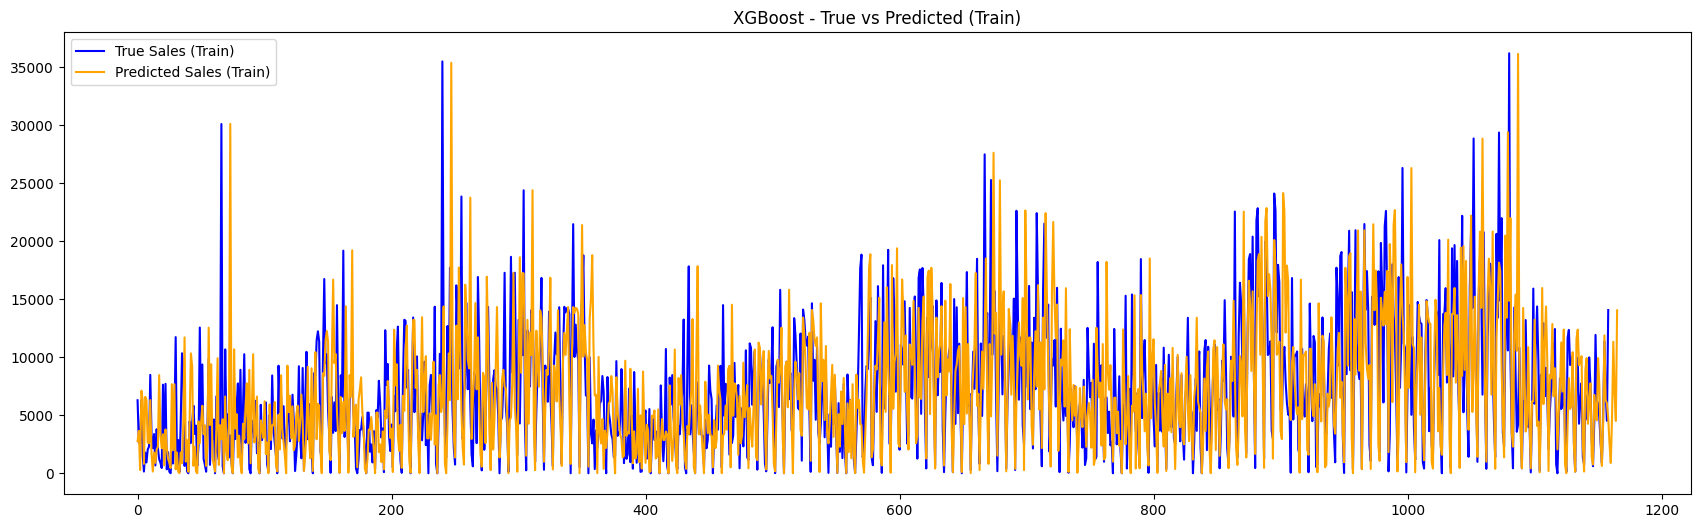

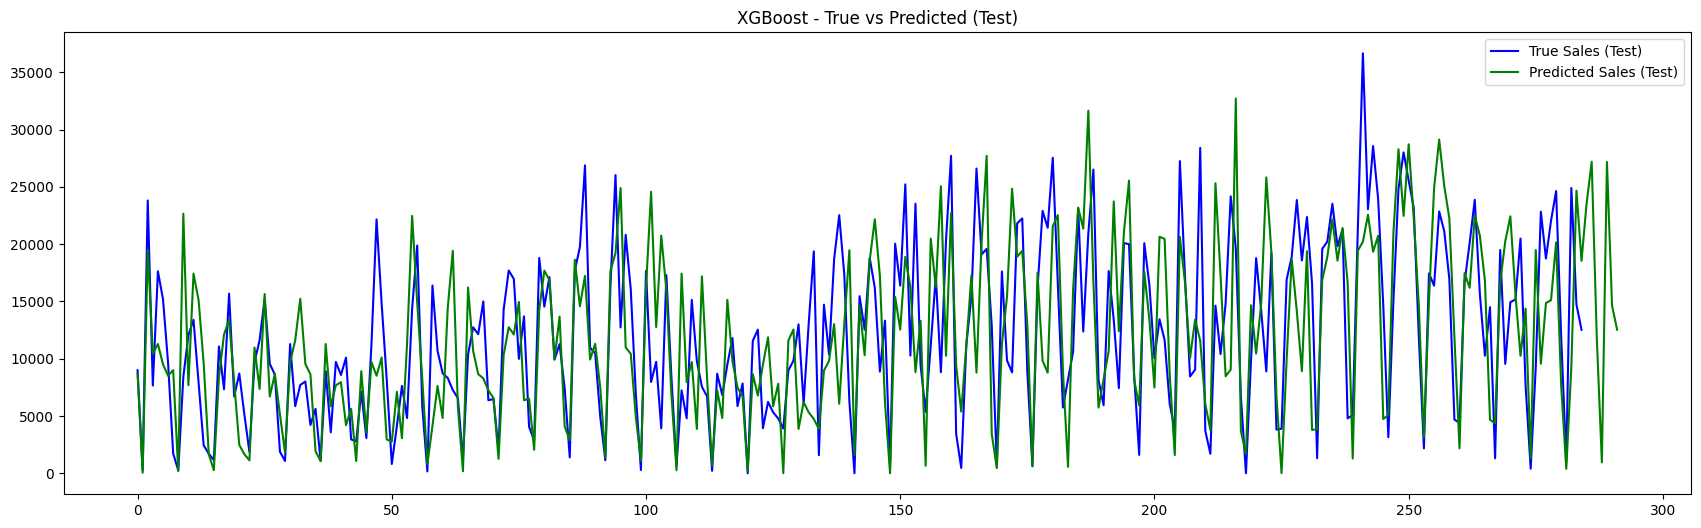

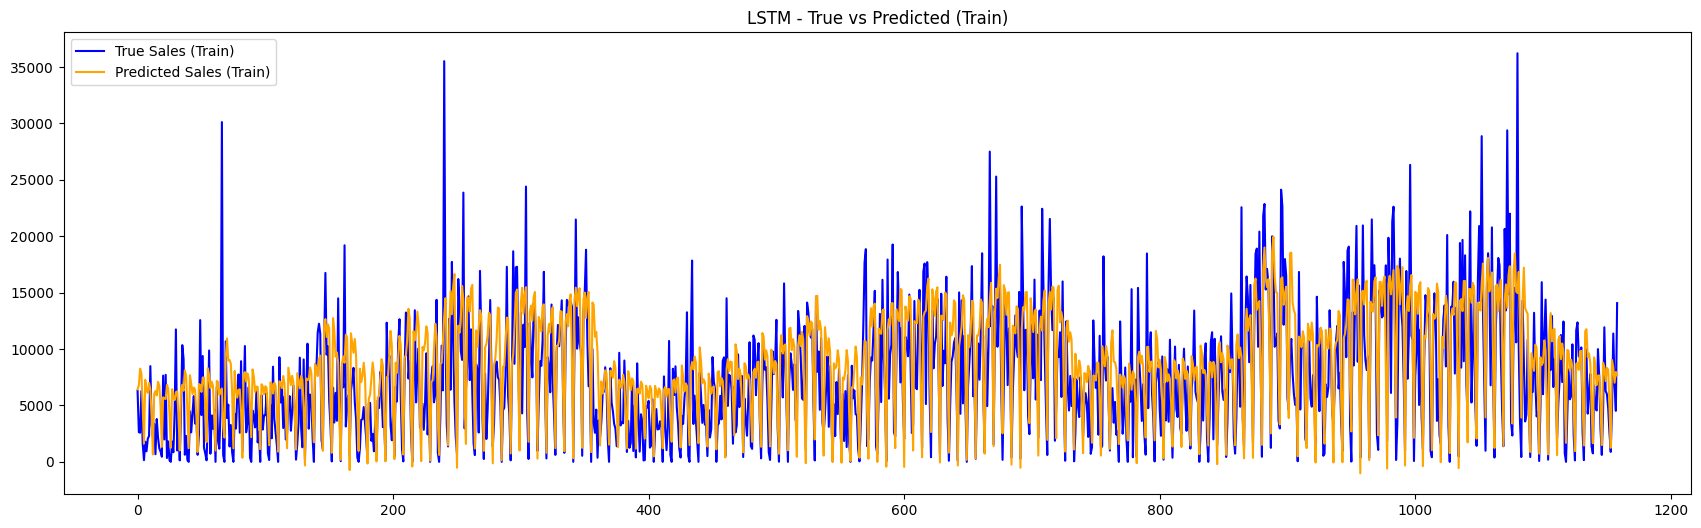

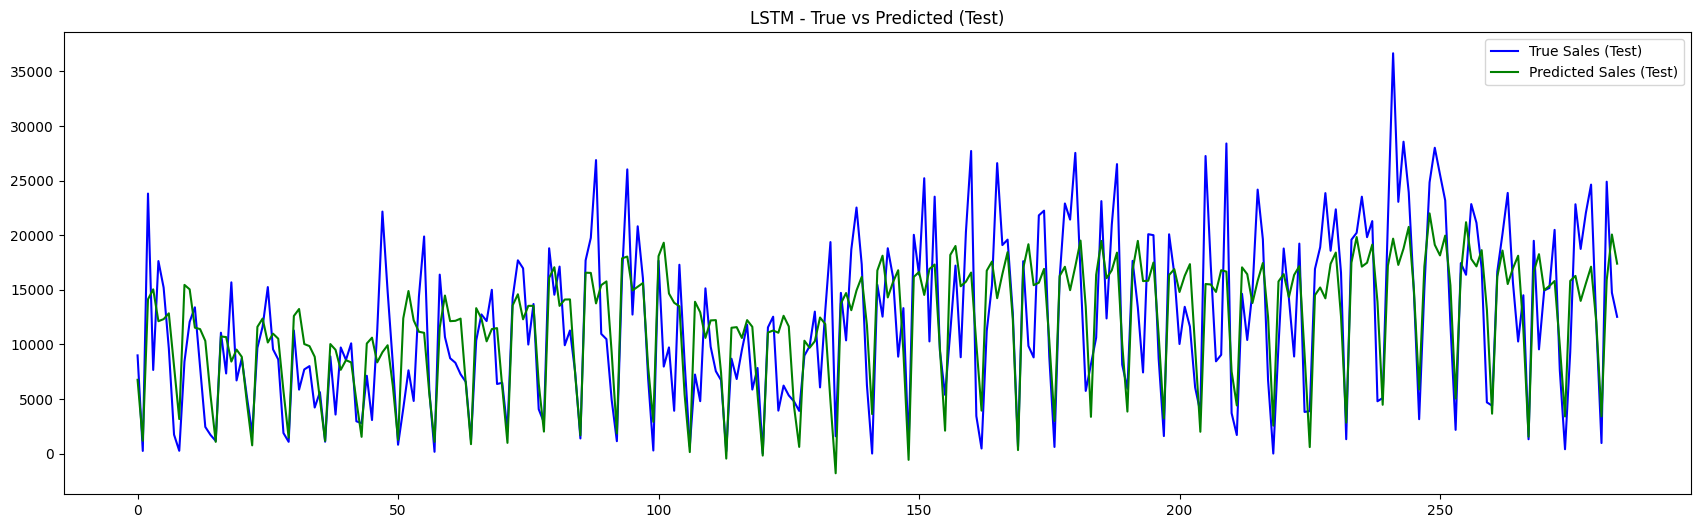

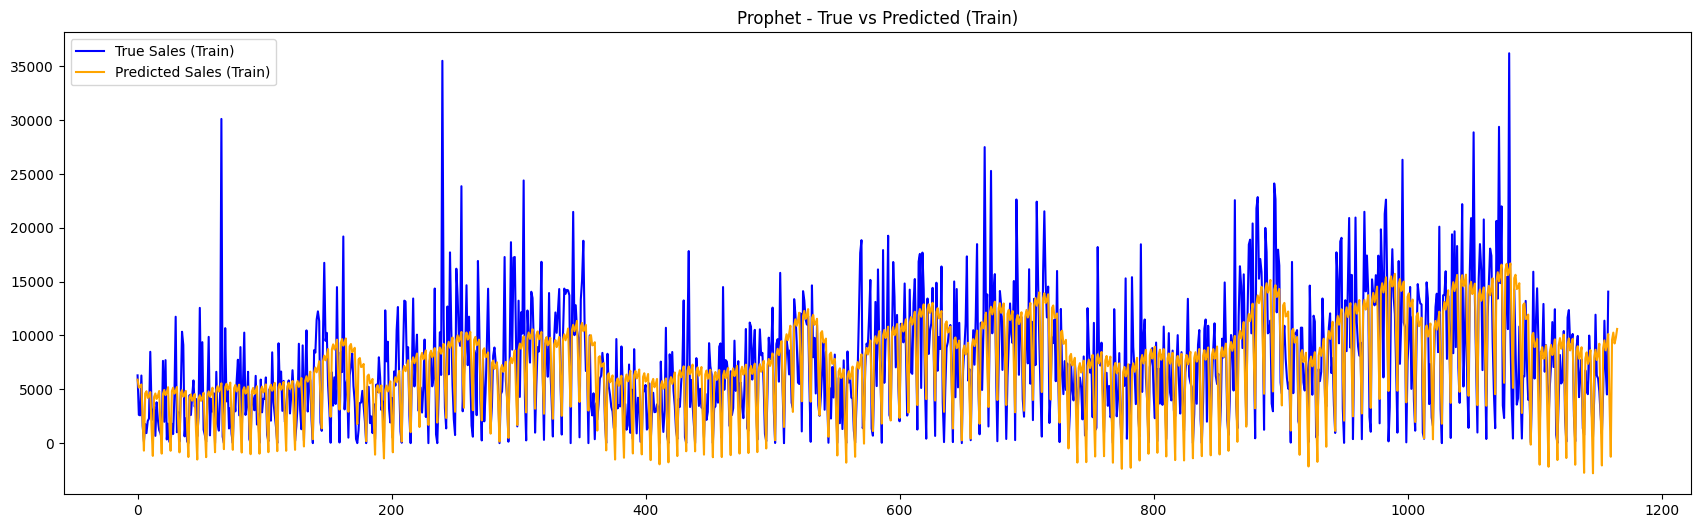

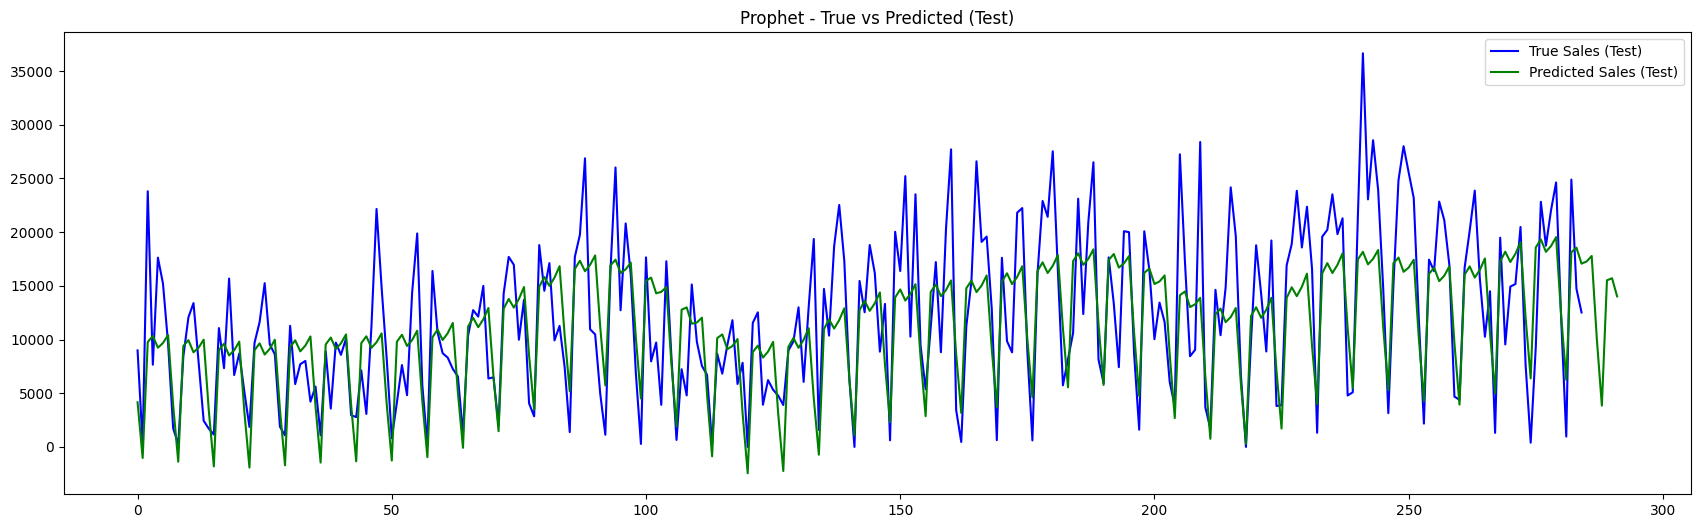

In [ ]:
# Plotting function for true vs predicted values for both train and test data
def plot_true_vs_predicted(true_values_train, train_pred, true_values_test, test_pred, model_name):
    # Plot for Train Data: True vs Predicted
    plt.figure(figsize=(21, 6))
    plt.plot(true_values_train, label="True Sales (Train)", color='blue')
    plt.plot(train_pred, label="Predicted Sales (Train)", color='orange')
    plt.title(f'{model_name} - True vs Predicted (Train)')
    plt.legend()
    plt.show()

    # Plot for Test Data: True vs Predicted
    plt.figure(figsize=(21, 6))
    plt.plot(true_values_test, label="True Sales (Test)", color='blue')
    plt.plot(test_pred, label="Predicted Sales (Test)", color='green')
    plt.title(f'{model_name} - True vs Predicted (Test)')
    plt.legend()
    plt.show()

# XGBoost Plot
plot_true_vs_predicted(
    true_values_train=y_train_true,
    train_pred=xgb_train_pred,
    true_values_test=y_test_true,
    test_pred=xgb_test_pred,
    model_name="XGBoost"
)

# LSTM Plot
plot_true_vs_predicted(
    true_values_train=y_train_true,
    train_pred=lstm_train_pred,
    true_values_test=y_test_true,
    test_pred=lstm_test_pred,
    model_name="LSTM"
)

# Prophet Plot
plot_true_vs_predicted(
    true_values_train=y_train_true,
    train_pred=prophet_train_pred,
    true_values_test=y_test_true,
    test_pred=prophet_test_pred,
    model_name="Prophet"
)